# Utilising Temporal Convolutional Networks for Cryptocurrency Price Forecasting

## Importing Libraries

#### Required Packages

In [ ]:
#!pip install keras-tcn
#!pip install scikeras
#!pip install keras-tuner
#!pip install tabulate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import random
from tabulate import tabulate

import time

from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_log_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.utils import resample

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam

from statsmodels.tsa.arima.model import ARIMA

from scikeras.wrappers import KerasRegressor

from tcn import TCN

## Dataset

The datasets, extracted from Binance through their [Binance API](https://binance-docs.github.io/apidocs/spot/en/), contains historical price data for the [Bitcoin (BTC)](https://www.binance.com/en/trade/BTC_USDT), [Etherium (ETH)](https://www.binance.com/en/trade/ETH_USDT), [Ripple (XRP)](https://www.binance.com/en/trade/XRP_USDT), [Binance Coin (BNB)](https://www.binance.com/en/trade/BNB_USDT) and [LTC (Litecoin)](https://www.binance.com/en/trade/LTC_USDT) cryptocurrencies at 15-minute intervals, covering the time period from 1st January 2024 until 30th May 2024. 

Below is an explanation of each column in the dataset:

- *open_time*: The date and time when the 15-minute interval ends. The format is in Unix Time Code.

- *open*: The opening price of the cryptocurrency at the start of the 15-minute interval.

- *high*: The highest price reached during the 15-minute interval.

- *low*: The lowest price reached during the 15-minute interval.

- *close*: The closing price at the end of the 15-minute interval.

- *volume*: The total amount of the cryptocurrency traded during the 15-minute interval.

- *close_time*: The close time of the 15-minute interval, represented as a Unix Time Code.

- *quote_volume*: The total trading volume in the quote currency (USDT) during the 15-minute interval.

- *count*: The total number of trades that occurred during the 30-minute interval.

- *taker_buy_volume*: The volume of the current cryptocurrency bought by takers (market buyers) during the 30-minute interval.

- *taker_buy_quote_volume*: The volume of the quote asset (USDT) spent by takers (market buyers) during the 30-minute interval.

### Data Exploration and Preprocessing

In [3]:
# Loading the datasets
btc_data = pd.read_csv('data/BTCUSDT-15m-2024-01-01-2024-05-30.csv')
eth_data = pd.read_csv('data/ETHUSDT-15m-2024-01-01-2024-05-30.csv')
bnb_data = pd.read_csv('data/BNBUSDT-15m-2024-01-01-2024-05-30.csv')
ltc_data = pd.read_csv('data/LTCUSDT-15m-2024-01-01-2024-05-30.csv')
xrp_data = pd.read_csv('data/XRPUSDT-15m-2024-01-01-2024-05-30.csv')

# For use to loop through methods
datasets = {'BTC': btc_data, 'ETH': eth_data, 'BNB': bnb_data, 'LTC': ltc_data, 'XRP': xrp_data}

#### Timestamp Conversion

In [4]:
# Converting 'open_time' from Unix timestamp to datetime format
btc_data['open_time'] = pd.to_datetime(btc_data['open_time'], unit='ms')
eth_data['open_time'] = pd.to_datetime(eth_data['open_time'], unit='ms')
bnb_data['open_time'] = pd.to_datetime(bnb_data['open_time'], unit='ms')
ltc_data['open_time'] = pd.to_datetime(ltc_data['open_time'], unit='ms')
xrp_data['open_time'] = pd.to_datetime(xrp_data['open_time'], unit='ms')

# Converting 'close_time' from Unix timestamp to datetime format
btc_data['close_time'] = pd.to_datetime(btc_data['close_time'], unit='ms')
eth_data['close_time'] = pd.to_datetime(eth_data['close_time'], unit='ms')
bnb_data['close_time'] = pd.to_datetime(bnb_data['close_time'], unit='ms')
ltc_data['close_time'] = pd.to_datetime(ltc_data['close_time'], unit='ms')
xrp_data['close_time'] = pd.to_datetime(xrp_data['close_time'], unit='ms')

print("Bitcoin Dataset:\n", btc_data.head())
print("\n\nEtherium Dataset:\n", eth_data.head())
print("\n\nBinance Coin Dataset:\n", bnb_data.head())
print("\n\nLitecoin Dataset:\n", ltc_data.head())
print("\n\nRipple Dataset:\n", xrp_data.head())

Bitcoin Dataset:
             open_time      open      high       low     close     volume  \
0 2024-01-01 00:00:00  42283.58  42488.09  42261.02  42488.00  431.71082   
1 2024-01-01 00:15:00  42488.00  42554.57  42412.02  42419.73  392.24889   
2 2024-01-01 00:30:00  42419.73  42447.82  42354.19  42441.32  319.90644   
3 2024-01-01 00:45:00  42441.32  42490.74  42422.45  42475.23  127.81493   
4 2024-01-01 01:00:00  42475.23  42475.23  42431.65  42466.33  188.76099   

               close_time  quote_volume  count  taker_buy_volume  \
0 2024-01-01 00:14:59.999  1.830469e+07  16651         248.76854   
1 2024-01-01 00:29:59.999  1.666186e+07  13332         175.52066   
2 2024-01-01 00:44:59.999  1.356409e+07  10959         192.00027   
3 2024-01-01 00:59:59.999  5.426608e+06   6192          66.28634   
4 2024-01-01 01:14:59.999  8.013008e+06   7256         115.17425   

   taker_buy_quote_volume  ignore  
0            1.054605e+07       0  
1            7.456566e+06       0  
2       

In [5]:
# Setting 'open_time' as the index
btc_data.set_index('open_time', inplace=True)
eth_data.set_index('open_time', inplace=True)
bnb_data.set_index('open_time', inplace=True)
ltc_data.set_index('open_time', inplace=True)
xrp_data.set_index('open_time', inplace=True)

#### Descriptive Statistics

In [5]:
descriptive_stats = ['open', 'high', 'low', 'close', 'volume']

btc_stats = btc_data[descriptive_stats].describe()
eth_stats = eth_data[descriptive_stats].describe()
bnb_stats = bnb_data[descriptive_stats].describe()
ltc_stats = ltc_data[descriptive_stats].describe()
xrp_stats = xrp_data[descriptive_stats].describe()

print("Bitcoin (BTC) - Descriptive Statistics:\n", btc_stats)
print("\n\nEtherium (ETH) - Descriptive Statistics:\n", eth_stats)
print("\n\nBinance Coin (BNB) - Descriptive Statistics:\n", bnb_stats)
print("\n\nLitecoin (LTC) - Descriptive Statistics:\n", ltc_stats)
print("\n\nRipple (XRP) - Descriptive Statistics:\n", xrp_stats)

Bitcoin (BTC) - Descriptive Statistics:
                open          high           low         close        volume
count  14496.000000  14496.000000  14496.000000  14496.000000  14496.000000
mean   58197.788724  58309.074634  58079.063784  58199.584860    443.996316
std    10628.238645  10655.497772  10598.580183  10627.752173    497.176554
min    38705.280000  38815.990000  38555.000000  38705.290000     18.545130
25%    46477.715000  46599.742500  46312.735000  46483.232500    176.663815
50%    62777.485000  62935.120000  62642.235000  62778.665000    295.374400
75%    67170.822500  67321.155000  67024.240000  67173.260000    515.978795
max    73607.800000  73777.000000  73400.000000  73607.800000   9072.870300


Etherium (ETH) - Descriptive Statistics:
                open          high           low         close         volume
count  14496.000000  14496.000000  14496.000000  14496.000000   14496.000000
mean    3052.742463   3059.498378   3045.468796   3052.843411    4637.615368


### Train-Test-Validation Split

The total dataset is divided into an in-sample dataset, for training and validation, and an out-of-sample dataset, for testing. 

The in-sample dataset constitutes 80% of the total data, while the out-of-sample dataset constitutes the remaining 20%.

Within the in-sample dataset, another split is performed to separate the training and validation sets. Here, approximately 80% of the in-sample data is allocated to the training set, and the remaining 20% is allocated to the validation set.

The following code is used to show how the data will be divided. The data splitting is repeated within the models' functions.

In [6]:
def split_and_plot(data, coin):
    total_data_points = len(data)
    in_sample_size = int(0.8 * total_data_points)
    out_sample_size = total_data_points - in_sample_size

    in_sample_data = data.iloc[:in_sample_size]
    out_sample_data = data.iloc[in_sample_size:]

    train_size = int(0.8 * len(in_sample_data))
    val_size = len(in_sample_data) - train_size

    train_data = in_sample_data.iloc[:train_size]
    val_data = in_sample_data.iloc[train_size:]

    # Output the split information
    print(f"{coin} Dataset:")
    print(f"Total data points: {total_data_points}\t\t| From: {data.index.min()} To: {data.index.max()}")
    print(f"In-sample data points: {len(in_sample_data)} ({len(in_sample_data)/total_data_points:.2%})\t| From: {in_sample_data.index.min()} To: {in_sample_data.index.max()}")
    print(f"Out-sample data points: {len(out_sample_data)} ({len(out_sample_data)/total_data_points:.2%})\t| From: {out_sample_data.index.min()} To: {out_sample_data.index.max()}")
    print(f"Training data points: {len(train_data)} ({len(train_data)/total_data_points:.2%})\t| From: {train_data.index.min()} To: {train_data.index.max()}")
    print(f"Validation data points: {len(val_data)} ({len(val_data)/total_data_points:.2%})\t| From: {val_data.index.min()} To: {val_data.index.max()}")
    print("\n")

    # Plot the data
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['close'], label='Total data', color='gray')
    plt.plot(train_data.index, train_data['close'], label='Training data', color='blue')
    plt.plot(val_data.index, val_data['close'], label='Validation data', color='orange')
    plt.plot(out_sample_data.index, out_sample_data['close'], label='Test data', color='green')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'{coin} - Closing Price Over Time with Train-Test-Validate Split')
    plt.legend()
    plt.show()

Bitcoin Dataset:
Total data points: 14496		| From: 2024-01-01 00:00:00 To: 2024-05-30 23:45:00
In-sample data points: 11596 (79.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-30 18:45:00
Out-sample data points: 2900 (20.01%)	| From: 2024-04-30 19:00:00 To: 2024-05-30 23:45:00
Training data points: 9276 (63.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-06 14:45:00
Validation data points: 2320 (16.00%)	| From: 2024-04-06 15:00:00 To: 2024-04-30 18:45:00




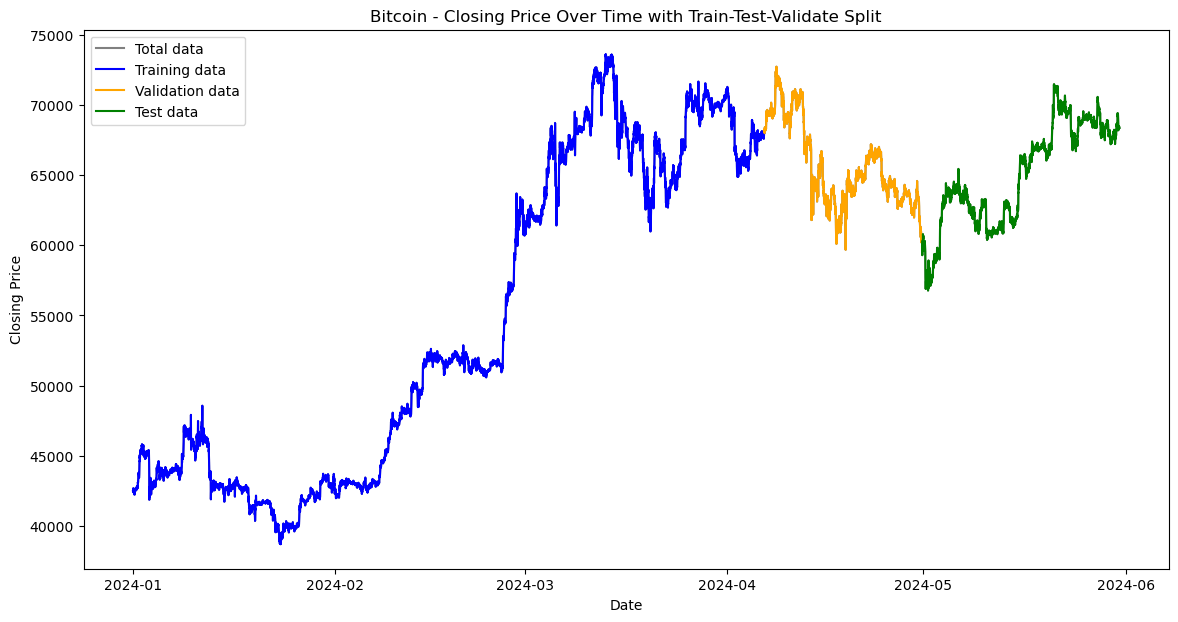

Ethereum Dataset:
Total data points: 14496		| From: 2024-01-01 00:00:00 To: 2024-05-30 23:45:00
In-sample data points: 11596 (79.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-30 18:45:00
Out-sample data points: 2900 (20.01%)	| From: 2024-04-30 19:00:00 To: 2024-05-30 23:45:00
Training data points: 9276 (63.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-06 14:45:00
Validation data points: 2320 (16.00%)	| From: 2024-04-06 15:00:00 To: 2024-04-30 18:45:00




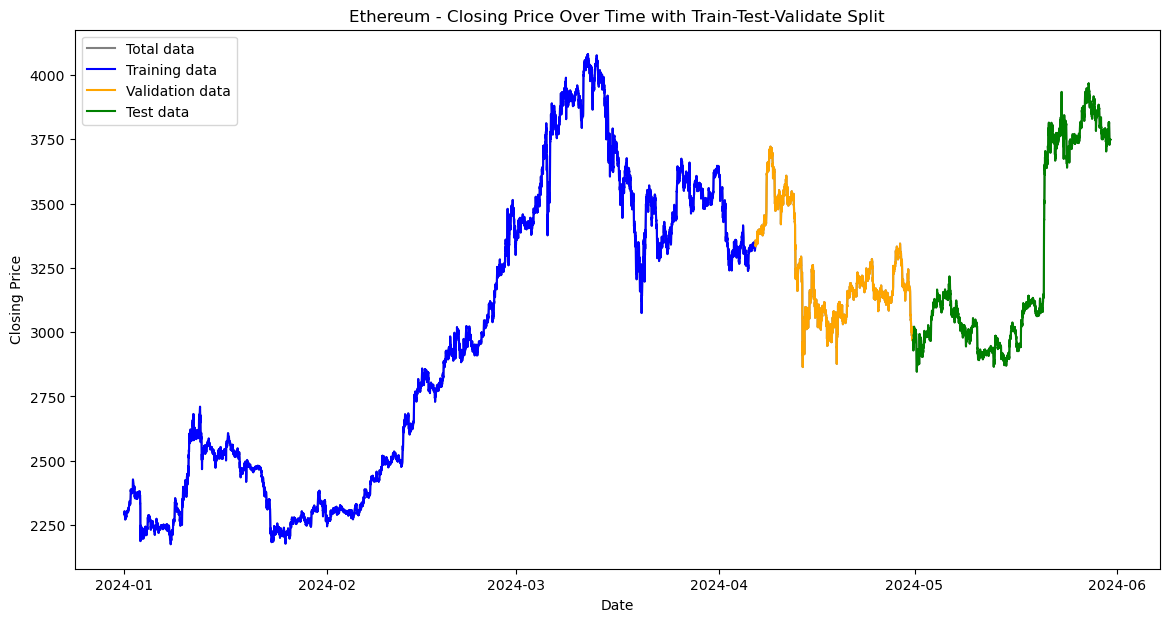

Binance Coin Dataset:
Total data points: 14496		| From: 2024-01-01 00:00:00 To: 2024-05-30 23:45:00
In-sample data points: 11596 (79.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-30 18:45:00
Out-sample data points: 2900 (20.01%)	| From: 2024-04-30 19:00:00 To: 2024-05-30 23:45:00
Training data points: 9276 (63.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-06 14:45:00
Validation data points: 2320 (16.00%)	| From: 2024-04-06 15:00:00 To: 2024-04-30 18:45:00




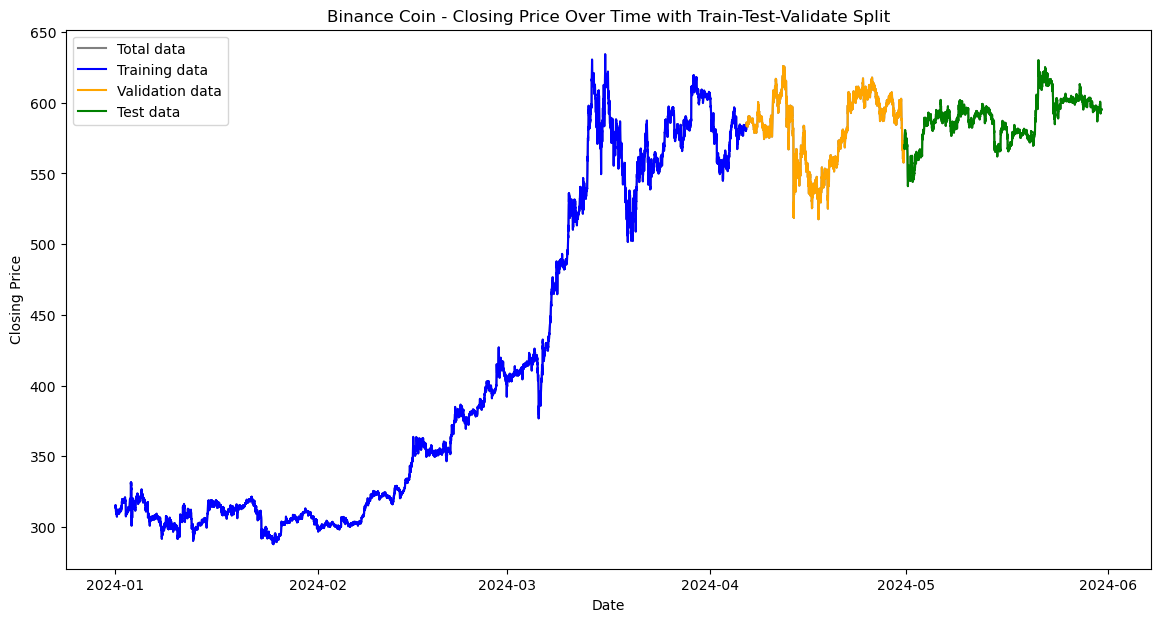

Litecoin Dataset:
Total data points: 14496		| From: 2024-01-01 00:00:00 To: 2024-05-30 23:45:00
In-sample data points: 11596 (79.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-30 18:45:00
Out-sample data points: 2900 (20.01%)	| From: 2024-04-30 19:00:00 To: 2024-05-30 23:45:00
Training data points: 9276 (63.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-06 14:45:00
Validation data points: 2320 (16.00%)	| From: 2024-04-06 15:00:00 To: 2024-04-30 18:45:00




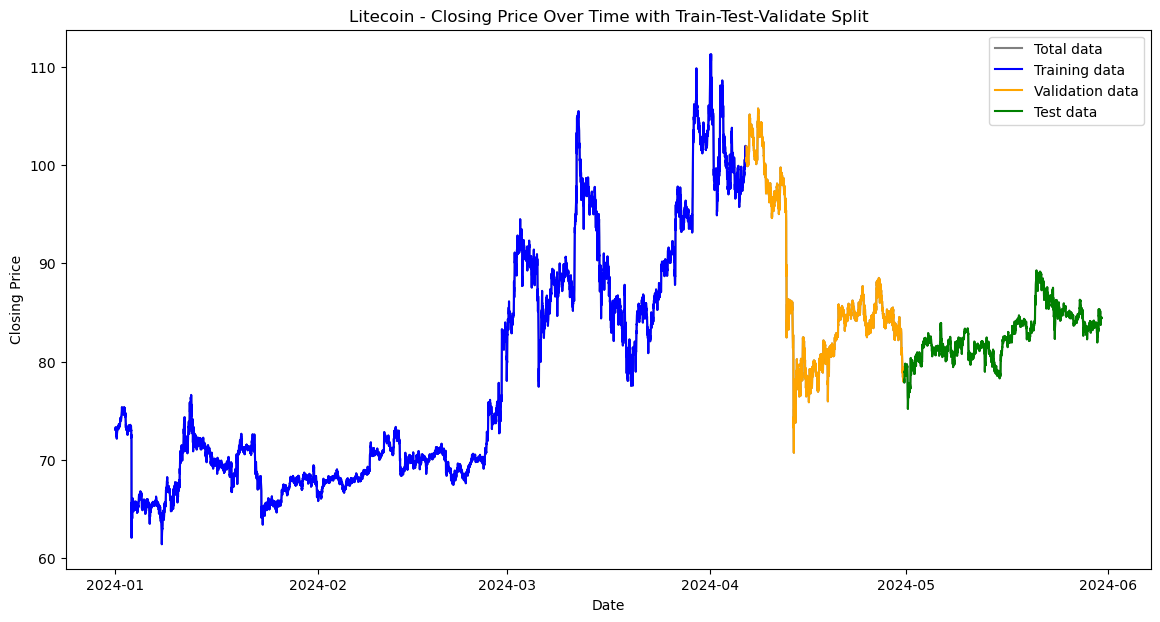

Ripple Dataset:
Total data points: 14496		| From: 2024-01-01 00:00:00 To: 2024-05-30 23:45:00
In-sample data points: 11596 (79.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-30 18:45:00
Out-sample data points: 2900 (20.01%)	| From: 2024-04-30 19:00:00 To: 2024-05-30 23:45:00
Training data points: 9276 (63.99%)	| From: 2024-01-01 00:00:00 To: 2024-04-06 14:45:00
Validation data points: 2320 (16.00%)	| From: 2024-04-06 15:00:00 To: 2024-04-30 18:45:00




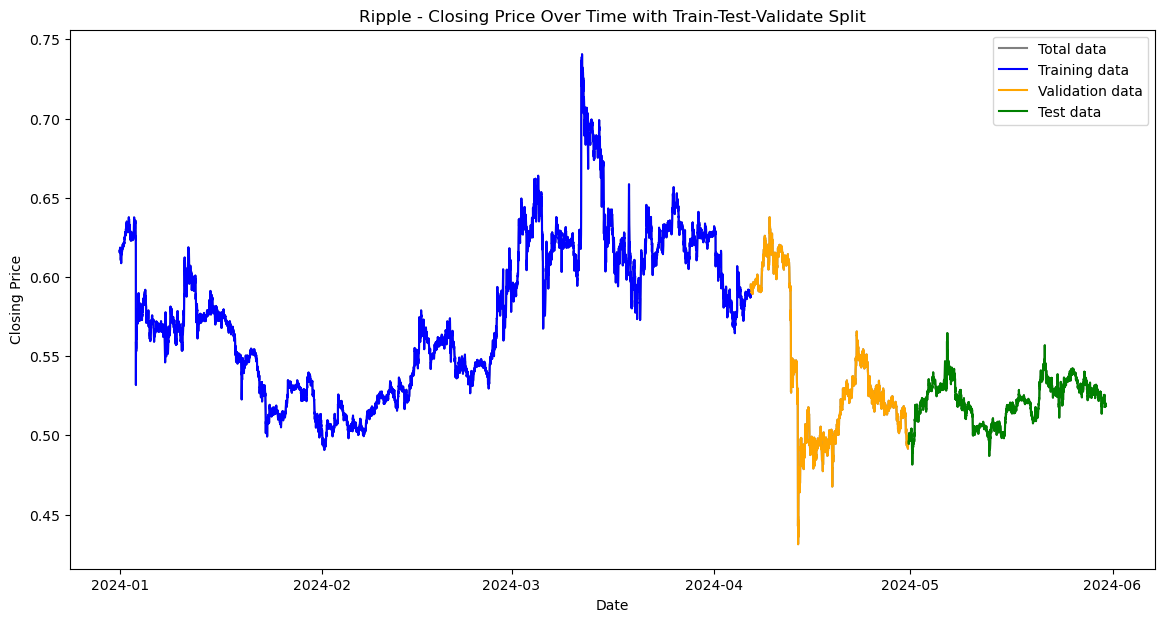

In [7]:
# Perform split and plot for each dataset
split_and_plot(btc_data, "Bitcoin")
split_and_plot(eth_data, "Ethereum")
split_and_plot(bnb_data, "Binance Coin")
split_and_plot(ltc_data, "Litecoin")
split_and_plot(xrp_data, "Ripple")

## Standard Values

In [8]:
# Initial Capital in USDT (to keep in line with dataset)
initial_capital = 1000
# Taking Binance's Spot Trading Fee (not including discount)
trading_fee = 0.001

In [9]:
# Dictionary to store the results
results = {
    'Naive_Forecast': {},
    'Buy_and_Hold': {},
    'ARIMA': {},
    'Moving_Average': {},
    'MACD': {},
    'RSI': {},
    'LSTM': {},
    'TCN': {},
    'TCN+Bagging': {},
    'TCN+Boosting': {}
}

## Baseline Models

In [10]:
# For Evaluation Metrics
def calculate_metrics(data):
    # Calculating the daily return
    data['daily_return'] = data['close'].pct_change()
    data['log_return'] = np.log(data['close'] / data['close'].shift(1))

    # Calculating the cumulative returns
    cum_return = data['close'].iloc[-1] / data['close'].iloc[0] - 1

    # Calculating the maximum gain
    cum_max = data['close'].cummax()
    max_gain = (data['close'] / cum_max).max()

    # Calculatmaximum drawdown
    drawdown = data['close'] / cum_max - 1
    max_drawdown = drawdown.min()

    # Calculating the annualized Sharpe Ratio
    risk_free_rate = 0.0  # Assuming risk-free rate is 0 for simplicity
    trading_days = 365 * 24 * 4  # 15-minute intervals per trading year
    annualized_return = data['log_return'].mean() * trading_days
    annualized_volatility = data['log_return'].std() * np.sqrt(trading_days)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return cum_return, max_gain, max_drawdown, sharpe_ratio

### Buy-and-Hold Strategy

A simple strategy whereby the coin is bought on the first available day, and only sold at the last available day in the dataset, regardless of any short-term fluctuations in the market.

This will be used as a benchmark against upcoming trading models.

In [14]:
def buy_and_hold(test_data, coin, trading_fee, initial_capital):
    test_data = test_data.copy()  # Make a copy to avoid the SettingWithCopyWarning

    initial_price = test_data['close'].iloc[0] * (1 + trading_fee)  # Buying at the closing price of the first trading day in the test dataset    
    final_price = test_data['close'].iloc[-1] * (1 - trading_fee)  # Holding and selling at the closing price of the last trading day in the test dataset
    
    amount_bought = initial_capital / initial_price  # Amount of cryptocurrency bought with initial capital (1000 USDT)
    final_balance = amount_bought * final_price  # Final capital after selling

    # Calculating the return and metrics
    total_return = (final_balance - initial_capital) / initial_capital * 100
    log_return = np.log(final_balance / initial_capital) * 100

    # (Using .loc to avoid SettingWithCopyWarning)
    test_data.loc[:, 'daily_return'] = test_data['close'].pct_change()
    test_data.loc[:, 'log_return'] = np.log(test_data['close'] / test_data['close'].shift(1))

    cumulative_return, max_gain, max_drawdown, sharpe_ratio = calculate_metrics(test_data)

    # Results output
    print(f"{coin} - Buy-and-Hold:\n")
    print(f"Total data points: {len(test_data)}")
    print(f"From {test_data.index.min()} until {test_data.index.max()}\n")
    print(f"Initial price: {initial_price:.2f}")
    print(f"Final Price: {final_price:.2f}\n")
    print(f"Final Balance: {final_balance:.2f} USDT")
    print(f"Gains/Losses: {final_balance - initial_capital:.2f} USDT")
    print(f"Total return: {total_return:.2f}%")
    print(f"Log return: {log_return:.2f}%")
    print(f"Cumulative return: {cumulative_return:.2f}%\n")
    print(f"Maximum Gain: {max_gain:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}\n\n")
    
    return {
        'rmse': 0, 
        'mae': 0,
        'mape': 0,
        'r2': 1,
        'msle': 0,
        'explained_variance': 1,
        'cumulative_return': cumulative_return,
        'final_balance': final_balance,
        'total_trades': 0,  # Since this model does not involve trading
        'directional_accuracy': 1,
        'max_gain': max_gain,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    }

In [15]:
for coin, data in datasets.items():
    # Splitting the dataset 80/20
    total_len = len(data)
    split_index = int(0.8 * total_len)
    test_data = data.iloc[split_index:]

    results['Buy_and_Hold'][coin] = buy_and_hold(test_data, coin, trading_fee, initial_capital)

BTC - Buy-and-Hold:

Total data points: 2900
From 2024-04-30 19:00:00 until 2024-05-30 23:45:00

Initial price: 60060.01
Final Price: 68283.82

Final Balance: 1136.93 USDT
Gains/Losses: 136.93 USDT
Total return: 13.69%
Log return: 12.83%
Cumulative return: 0.14%

Maximum Gain: 1.00%
Maximum Drawdown: -0.08%
Annualized Sharpe Ratio: 3.41


ETH - Buy-and-Hold:

Total data points: 2900
From 2024-04-30 19:00:00 until 2024-05-30 23:45:00

Initial price: 2956.33
Final Price: 3744.16

Final Balance: 1266.49 USDT
Gains/Losses: 266.49 USDT
Total return: 26.65%
Log return: 23.62%
Cumulative return: 0.27%

Maximum Gain: 1.00%
Maximum Drawdown: -0.11%
Annualized Sharpe Ratio: 4.64


BNB - Buy-and-Hold:

Total data points: 2900
From 2024-04-30 19:00:00 until 2024-05-30 23:45:00

Initial price: 568.97
Final Price: 594.50

Final Balance: 1044.88 USDT
Gains/Losses: 44.88 USDT
Total return: 4.49%
Log return: 4.39%
Cumulative return: 0.05%

Maximum Gain: 1.00%
Maximum Drawdown: -0.07%
Annualized Sharpe 

### Naïve Forecast

This is another simplistic method, however some prediction measures are now introduced, by predicting the future prices based on the most recent observations. This is done by shifting the close price by a period to get the predicted prices.

This strategy will also be mainly used as a benchmark for the LSTM and TCN model.

In [79]:
# Naive forecast model with additional statistics
def naive_forecast(data, coin):
    # Shifting the close prices by 1 period to get the predicted prices
    predicted_prices = data['close'].shift(1)

    # Calculating the return
    data['returns'] = data['close'].pct_change()
    data['predicted_returns'] = predicted_prices.pct_change()

    # Evaluation Metrics
    mae = np.mean(np.abs(data['close'] - predicted_prices))
    mse = np.mean((data['close'] - predicted_prices)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((data['close'] - predicted_prices) / data['close'])) * 100
    da = (np.sign(data['returns']) == np.sign(data['predicted_returns'])).mean() * 100

    # Output results
    print(f"{coin} - Naive Forecast:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Directional Accuracy (DA): {da:.2f}%")
    print("\n")

    # Actual vs Predicted Closing Prices
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['close'], label='Actual Closing Price', color='blue')
    plt.plot(data.index, predicted_prices, label='Predicted Closing Price', linestyle='--', color='red')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'{coin} Naive Forecast: Actual vs Predicted Closing Price')
    plt.legend()
    plt.show()
    
    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'da': da
    }

BTC - Naive Forecast:
Mean Absolute Error (MAE): 116.17
Mean Squared Error (MSE): 32336.43
Root Mean Squared Error (RMSE): 179.82
Mean Absolute Percentage Error (MAPE): 0.20%
Directional Accuracy (DA): 47.52%




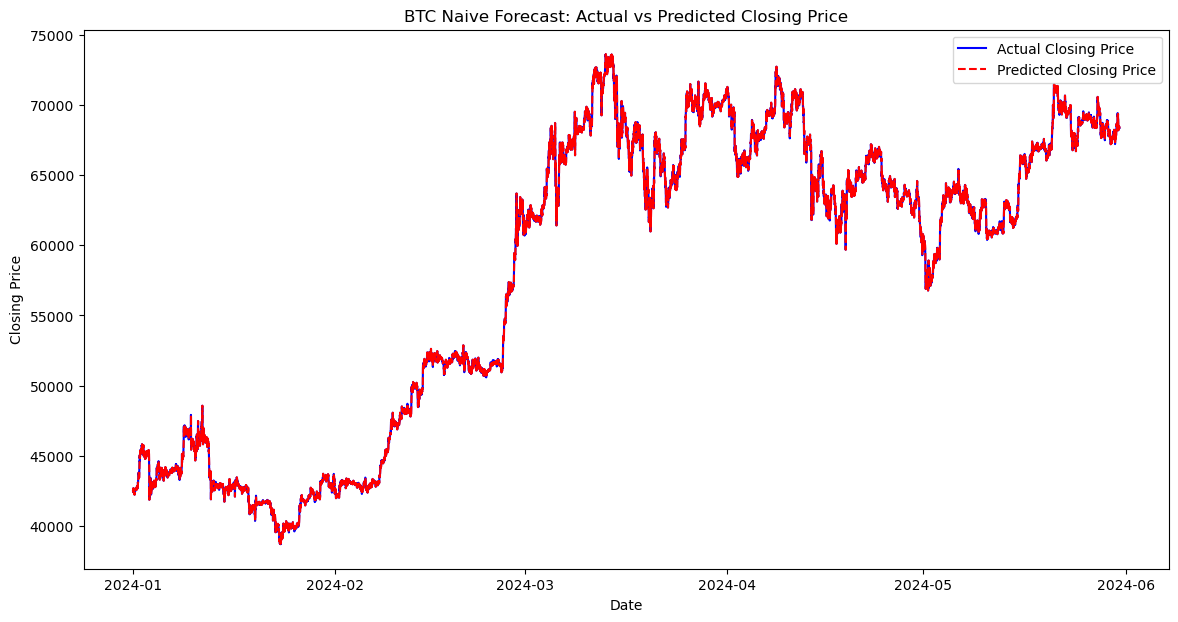

ETH - Naive Forecast:
Mean Absolute Error (MAE): 7.03
Mean Squared Error (MSE): 120.41
Root Mean Squared Error (RMSE): 10.97
Mean Absolute Percentage Error (MAPE): 0.23%
Directional Accuracy (DA): 48.05%




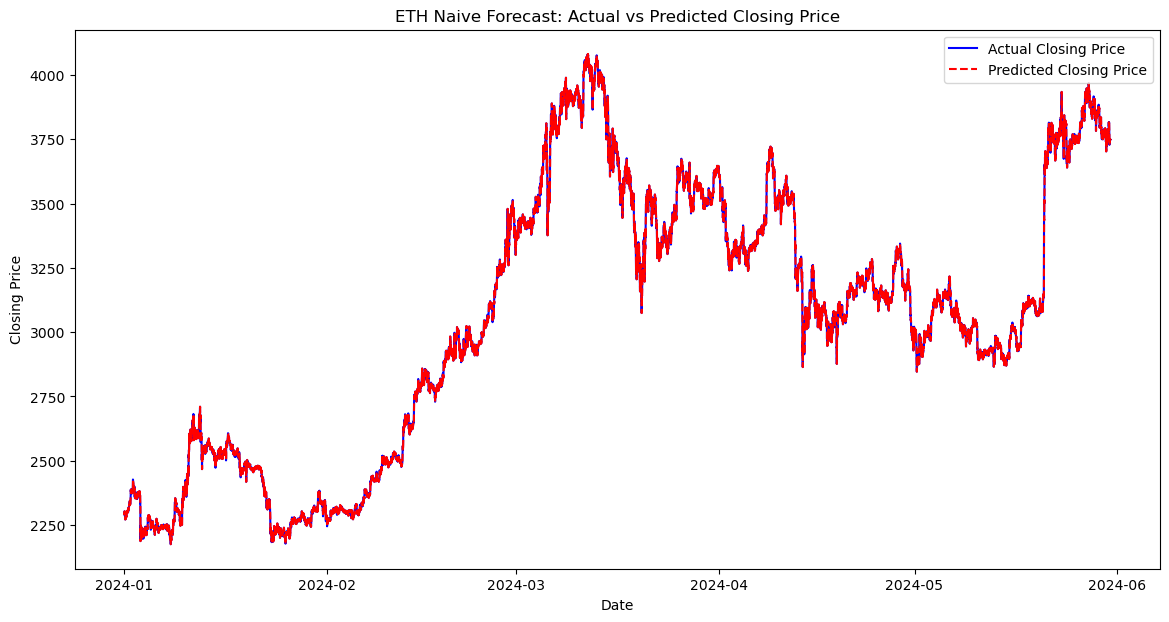

BNB - Naive Forecast:
Mean Absolute Error (MAE): 1.10
Mean Squared Error (MSE): 3.09
Root Mean Squared Error (RMSE): 1.76
Mean Absolute Percentage Error (MAPE): 0.23%
Directional Accuracy (DA): 44.41%




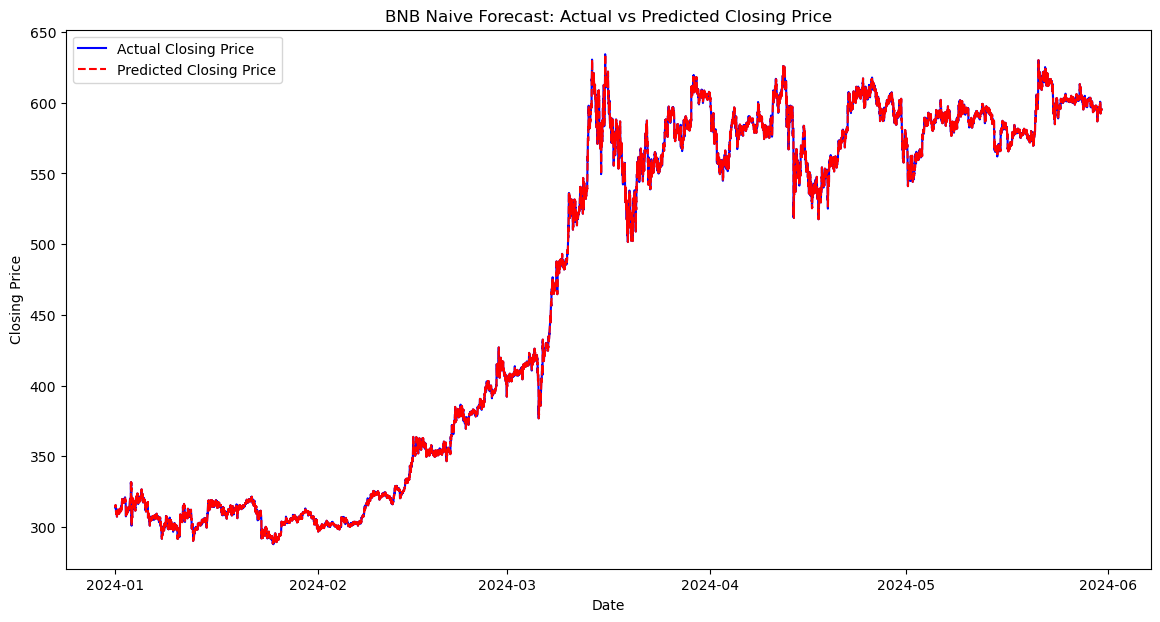

LTC - Naive Forecast:
Mean Absolute Error (MAE): 0.22
Mean Squared Error (MSE): 0.13
Root Mean Squared Error (RMSE): 0.36
Mean Absolute Percentage Error (MAPE): 0.27%
Directional Accuracy (DA): 46.25%




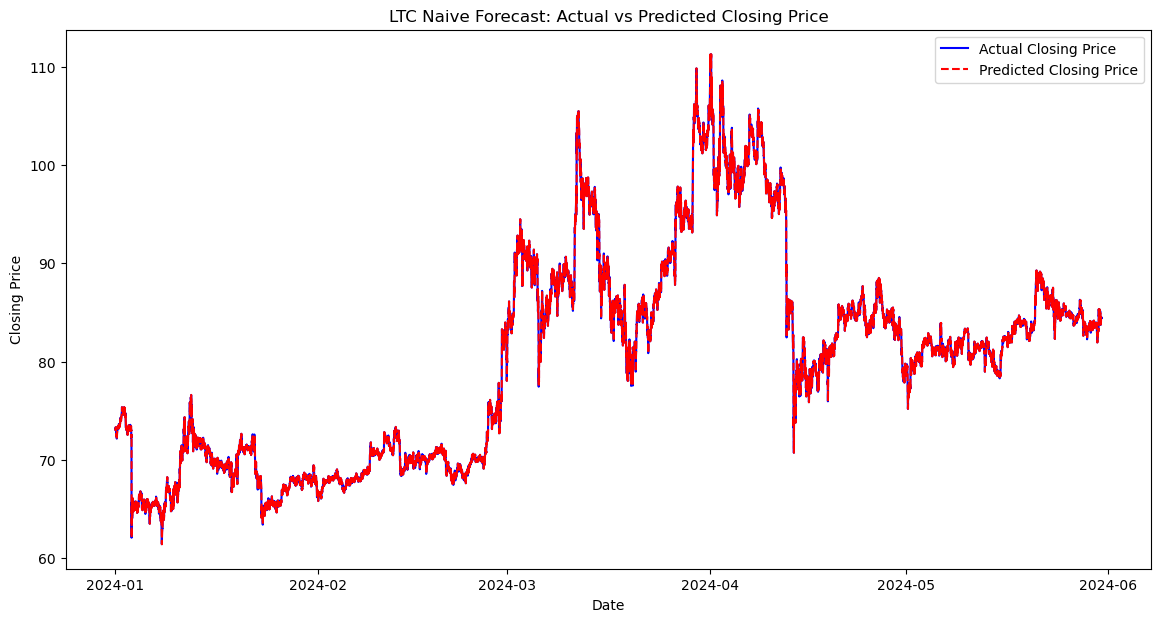

XRP - Naive Forecast:
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
Mean Absolute Percentage Error (MAPE): 0.24%
Directional Accuracy (DA): 44.83%




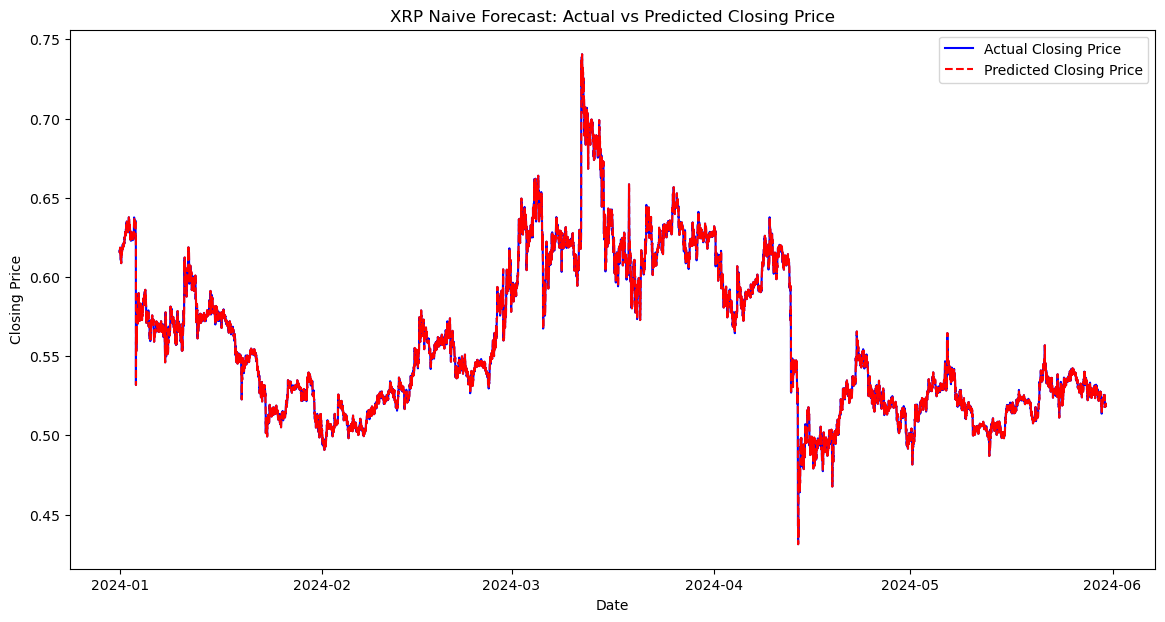

In [80]:
for coin, data in datasets.items():
    results['Naive_Forecast'][coin] = naive_forecast(data, coin)

### ARIMA Model

In [73]:
def arima_model(data, coin):
    # Splitting data into only train and test
    split = int(0.8 * len(data))
    train_data, test_data = data.iloc[:split], data.iloc[split:]

    # Training the ARIMA model
    arima_model = ARIMA(train_data['close'], order=(5,1,0))
    arima_fit = arima_model.fit()

    # Forecasting
    arima_forecast = arima_fit.forecast(steps=len(test_data))

    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(test_data['close'], arima_forecast))
    mae = mean_absolute_error(test_data['close'], arima_forecast)
    mape = np.mean(np.abs((test_data['close'] - arima_forecast) / test_data['close'])) * 100
    r2 = r2_score(test_data['close'], arima_forecast)
    msle = mean_squared_log_error(test_data['close'], arima_forecast)
    explained_variance = explained_variance_score(test_data['close'], arima_forecast)

    print(f"{coin} - ARIMA Model:")
    print(f'Root Mean Squared Error (RMSE) for {coin}: {rmse}')
    print(f'Mean Absolute Error (MAE) for {coin}: {mae}')
    print(f'Mean Absolute Percentage Error (MAPE) for {coin}: {mape}')
    print(f'R-squared (R²) Score for {coin}: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE) for {coin}: {msle}')
    print(f'Explained Variance Score for {coin}: {explained_variance}')

    # Actual vs Predicted
    plt.figure(figsize=(14, 7))
    plt.plot(train_data.index, train_data['close'], label='Training Data', color='blue')
    plt.plot(test_data.index, test_data['close'], label='Test Data', color='green')
    plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='red')
    plt.title(f'{coin} - ARIMA Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance
    }

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


BTC - ARIMA Model:
Root Mean Squared Error (RMSE) for BTC: 5798.923355035674
Mean Absolute Error (MAE) for BTC: 4883.347020782354
Mean Absolute Percentage Error (MAPE) for BTC: 7.287931171071438
R-squared (R²) Score for BTC: -1.64354190741071
Mean Squared Logarithmic Error (MSLE) for BTC: 0.008166254795818
Explained Variance Score for BTC: -1.161353583967184e-06


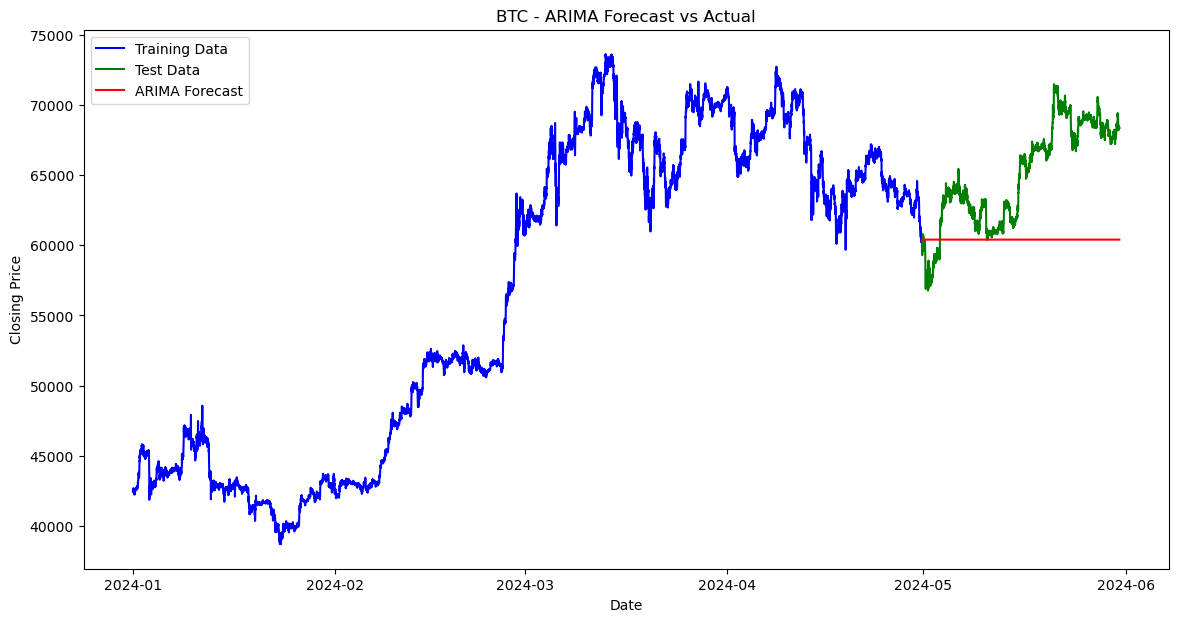

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ETH - ARIMA Model:
Root Mean Squared Error (RMSE) for ETH: 477.2761542693553
Mean Absolute Error (MAE) for ETH: 322.8214882034768
Mean Absolute Percentage Error (MAPE) for ETH: 8.83723603541205
R-squared (R²) Score for ETH: -0.6413198736887562
Mean Squared Logarithmic Error (MSLE) for ETH: 0.020159097127327164
Explained Variance Score for ETH: 2.2043101866042747e-07


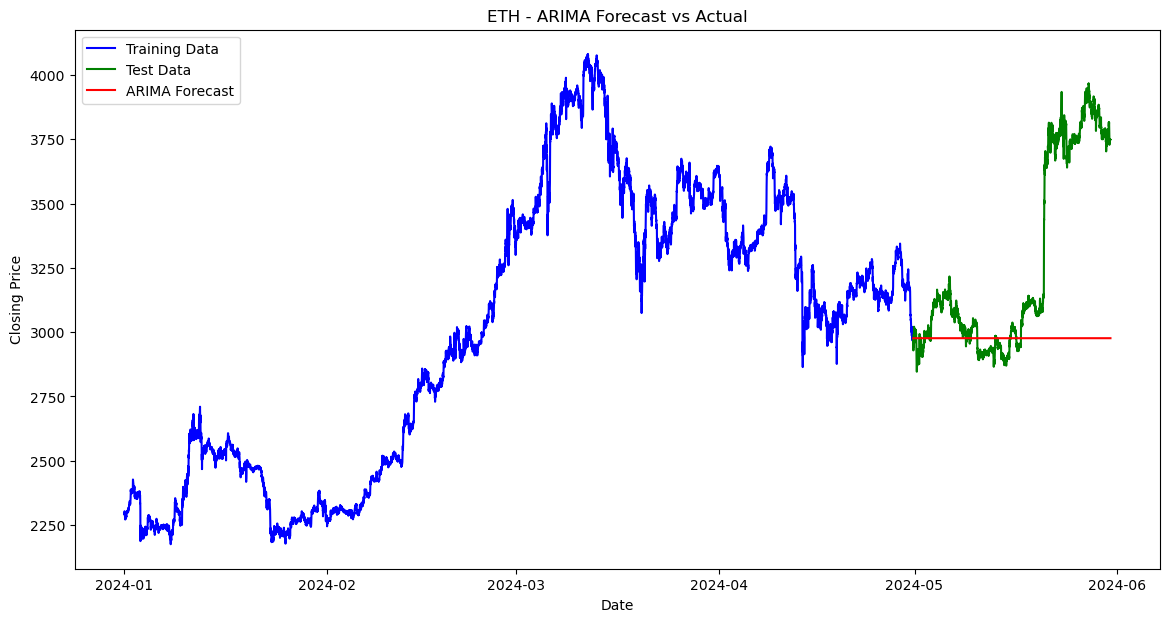

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


BNB - ARIMA Model:
Root Mean Squared Error (RMSE) for BNB: 22.908502084796993
Mean Absolute Error (MAE) for BNB: 19.809181790740396
Mean Absolute Percentage Error (MAPE) for BNB: 3.325598503643048
R-squared (R²) Score for BNB: -1.3186915615040737
Mean Squared Logarithmic Error (MSLE) for BNB: 0.0015223227259795029
Explained Variance Score for BNB: -3.1801965292288514e-06


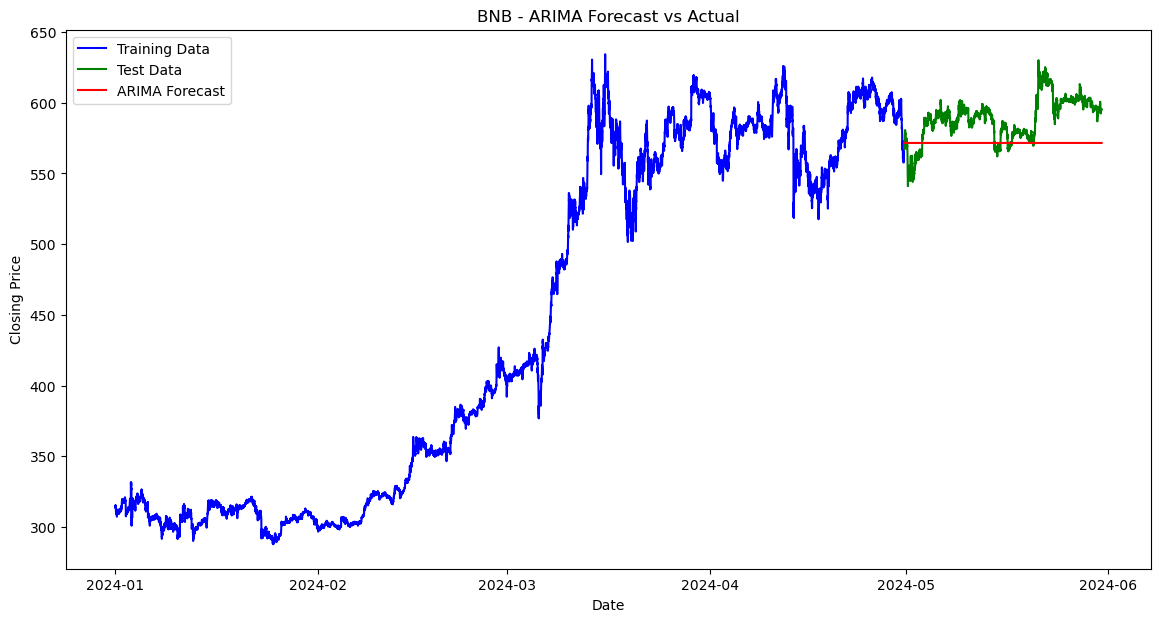

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


LTC - ARIMA Model:
Root Mean Squared Error (RMSE) for LTC: 4.821537810215347
Mean Absolute Error (MAE) for LTC: 4.259495856083599
Mean Absolute Percentage Error (MAPE) for LTC: 5.077249720253847
R-squared (R²) Score for LTC: -3.2209886170144255
Mean Squared Logarithmic Error (MSLE) for LTC: 0.003404606790874781
Explained Variance Score for LTC: -1.0332518914024647e-05


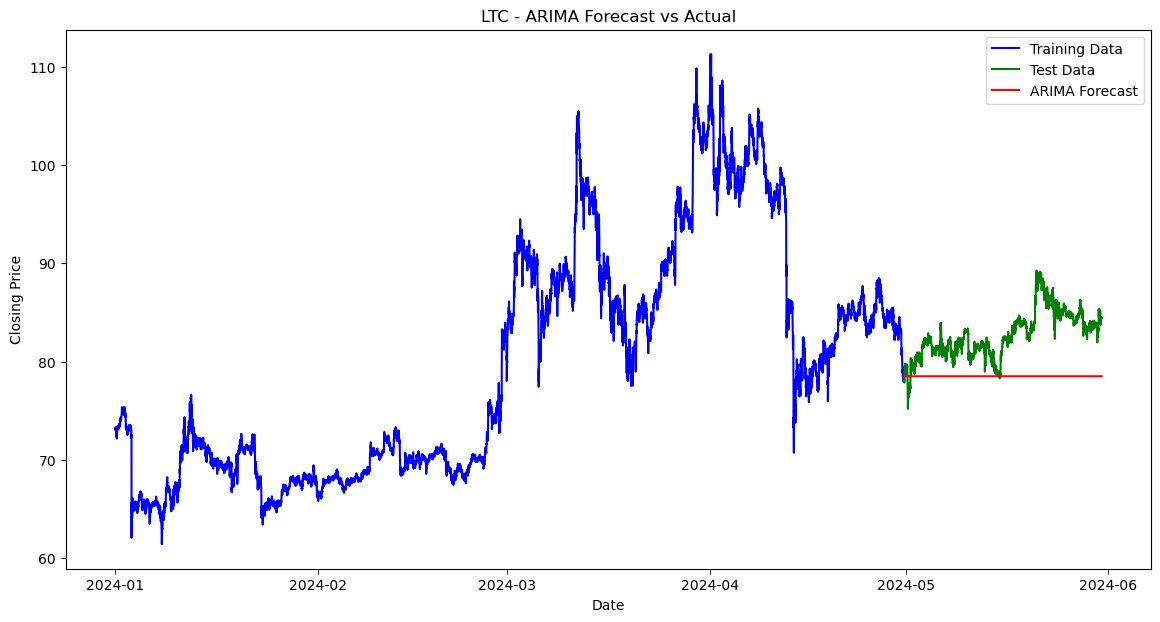

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


XRP - ARIMA Model:
Root Mean Squared Error (RMSE) for XRP: 0.027777947063867974
Mean Absolute Error (MAE) for XRP: 0.024999408109489286
Mean Absolute Percentage Error (MAPE) for XRP: 4.737312715405278
R-squared (R²) Score for XRP: -3.9776058344346277
Mean Squared Logarithmic Error (MSLE) for XRP: 0.0003366036687213224
Explained Variance Score for XRP: 6.318348768297177e-06


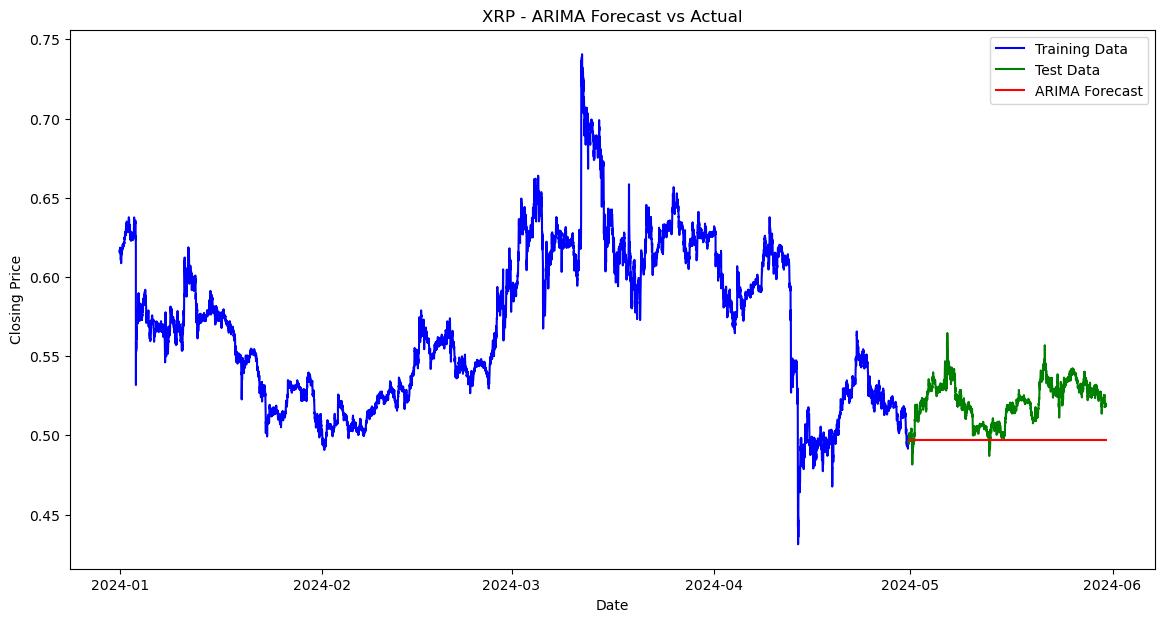

In [74]:
#Training and evaluating the data per coin
for coin, data in datasets.items():
     results['ARIMA'][coin] = arima_model(data, coin)

## Technical Indicators

Three technical indicator strategies will be tested, being:

*Trend Indicators:*
1. Moving Averages (MA)
2. Moving Average Convergence Divergence (MACD)

*Momentum Indicator:*

3. Relative Strength Index (RSI)

#### Backtesting

In [10]:
# Backtesting
def backtesting(data):
    capital = initial_capital  # Initial capital (1000 USDT)
    coins = 0  # Initial number of coins

    for i in range(1, len(data)):
        if data['positions'].iloc[i] == 1:  # Buy signal
            coins += capital / data['close'].iloc[i]  # Buying with available capital
            capital = 0
        elif data['positions'].iloc[i] == -1:  # Selling signal
            capital += coins * data['close'].iloc[i] * (1 - trading_fee)  # Selling every available coin
            coins = 0

    final_balance = capital + coins * data['close'].iloc[-1] * (1 - trading_fee)
    return final_balance

### Moving Averages (MA) Strategy

- This strategy uses two moving averages, short-term (20-day) and long-term (50-day).
- Buy signals when the short-term MA crossed above the long-term MA
- Sell signals when the short-term MA crossed below the long-term MA.
- The strategy is then backtested by simulating trades based on these signals.

In [16]:
def moving_average(data, short_window=20, long_window=50):
    data['short_ma'] = data['close'].rolling(window=short_window, min_periods=1).mean()  # Short-Term MAs
    data['long_ma'] = data['close'].rolling(window=long_window, min_periods=1).mean()  # Long-Term MAs

    # Generating the trading signals
    signal = np.zeros(len(data))  # Initialising the signal array with zeros
    signal[short_window:] = np.where(data['short_ma'][short_window:] > data['long_ma'][short_window:], 1, 0)
    data['signal'] = signal
    data['positions'] = data['signal'].diff()

    # Backtesting
    final_balance = backtesting(data)
    
    # Calculate the evaluation metrics metrics
    cumulative_return, max_gain, max_drawdown, sharpe_ratio = calculate_metrics(data)
    total_trades = np.count_nonzero(data['positions'])

    print(f'\n{coin} - Moving Average:')
    print(f"Final Balance for {coin}: {final_balance:.2f} USDT")
    print(f"Cumulative Return for {coin}: {cumulative_return:.2f}%")
    print(f"Total Trades for {coin}: {total_trades}")
    
    return {
        'cumulative_return': cumulative_return,
        'final_balance': final_balance,
        'total_trades': total_trades,
        'max_gain': max_gain,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    }

In [17]:
for coin, data in datasets.items():
    moving_avg_results = moving_average(data.copy())
    results['Moving_Average'][coin] = moving_avg_results


BTC - Moving Average:
Final Balance for BTC: 1195.05 USDT
Cumulative Return for BTC: 0.61%
Total Trades for BTC: 349

ETH - Moving Average:
Final Balance for ETH: 1099.35 USDT
Cumulative Return for ETH: 0.63%
Total Trades for ETH: 335

BNB - Moving Average:
Final Balance for BNB: 995.86 USDT
Cumulative Return for BNB: 0.90%
Total Trades for BNB: 333

LTC - Moving Average:
Final Balance for LTC: 769.26 USDT
Cumulative Return for LTC: 0.15%
Total Trades for LTC: 351

XRP - Moving Average:
Final Balance for XRP: 332.06 USDT
Cumulative Return for XRP: -0.16%
Total Trades for XRP: 375


**Moving Average Results:**

| Coin | Final Balance (USDT) | Cumulative Return (%) | Total Trades |
|------|----------------------|-----------------------|--------------|
| BTC  | 1195.05              | 0.61                  | 349          |
| ETH  | 1099.35              | 0.63                  | 335          |
| BNB  | 995.86               | 0.90                  | 333          |
| LTC  | 769.26               | 0.15                  | 351          |
| XRP  | 332.06               | -0.16                 | 375          |


### Moving Average Convergence Divergence (MACD) Strategy

- The MACD line (difference between 12-day and 26-day Exponential MAs) is calculated.
- Buy signals are generated when the MACD line crossed above the signal line (9-day EMA of MACD)
- Sell signals are generated when the MACD line crossed below the signal line.
- The strategy is then backtested by simulating trades based on these signals.


In [18]:
def macd_strategy(data, short_window=12, long_window=26, signal_window=9):
    data['short_ema'] = data['close'].ewm(span=short_window, adjust=False).mean()  # Short-Term Exponential MAs
    data['long_ema'] = data['close'].ewm(span=long_window, adjust=False).mean()  # Long-Term Exponential MAs
    
    data['macd'] = data['short_ema'] - data['long_ema']  # MACD Line
    data['signal_line'] = data['macd'].ewm(span=signal_window, adjust=False).mean()  # Signal Line

    # Generating the trading signals based on MACD crossovers
    data['positions'] = np.where(data['macd'] > data['signal_line'], 1, 0)
    data['positions'] = data['positions'].diff()

    # Backtesting
    final_balance = backtesting(data)
    
    # Calculating evaluation metrics
    cumulative_return, max_gain, max_drawdown, sharpe_ratio = calculate_metrics(data)
    total_trades = np.count_nonzero(data['positions'])
    
    print(f'\n{coin} -  MACD Strategy:')
    print(f"Final Balance for {coin}: {final_balance:.2f} USDT")
    print(f"Cumulative Return for {coin}: {cumulative_return:.2f}%")
    print(f"Total Trades for {coin}: {total_trades}")
    
    return {
        'cumulative_return': cumulative_return,
        'final_balance': final_balance,
        'total_trades': total_trades,
        'max_gain': max_gain,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    }

In [19]:
for coin, data in datasets.items():
    macd_results = macd_strategy(data.copy())
    results['MACD'][coin] = macd_results


BTC -  MACD Strategy:
Final Balance for BTC: 512.59 USDT
Cumulative Return for BTC: 0.61%
Total Trades for BTC: 1221

ETH -  MACD Strategy:
Final Balance for ETH: 691.69 USDT
Cumulative Return for ETH: 0.63%
Total Trades for ETH: 1176

BNB -  MACD Strategy:
Final Balance for BNB: 631.96 USDT
Cumulative Return for BNB: 0.90%
Total Trades for BNB: 1172

LTC -  MACD Strategy:
Final Balance for LTC: 432.36 USDT
Cumulative Return for LTC: 0.15%
Total Trades for LTC: 1198

XRP -  MACD Strategy:
Final Balance for XRP: 545.53 USDT
Cumulative Return for XRP: -0.16%
Total Trades for XRP: 1193


**MACD Strategy Results:**

| Coin | Final Balance (USDT) | Cumulative Return (%) | Total Trades |
|------|----------------------|-----------------------|--------------|
| BTC  | 512.59               | 0.61                  | 1221         |
| ETH  | 691.69               | 0.63                  | 1176         |
| BNB  | 631.96               | 0.90                  | 1172         |
| LTC  | 432.36               | 0.15                  | 1198         |
| XRP  | 545.53               | -0.16                 | 1193         |


### Relative Strength Index (RSI) Strategy

- The RSI is calculated using a 14-day window.
- Buy signals are generated when the RSI fell below 30, indicating oversold conditions.
- Sell signals are generated when the RSI rose above 70, indicating overbought conditions.
- The strategy is then backtested by simulating trades based on these signals.

In [20]:
def rsi_strategy(data, window=14, overbought=70, oversold=30):
    # Price differences
    delta = data['close'].diff()

    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    avg_gains = gains.rolling(window=window, min_periods=1).mean()
    avg_losses = losses.rolling(window=window, min_periods=1).mean()

    # Calculating RSI
    rs = avg_gains / avg_losses
    rsi = 100 - (100 / (1 + rs))

    # Generating trading signals based on RSI levels
    data['positions'] = np.where(rsi > overbought, -1, np.nan)  # Sell signal
    data['positions'] = np.where(rsi < oversold, 1, data['positions'])  # Buy signal
    data['positions'] = data['positions'].ffill().fillna(0).astype(int)

    # Backtesting
    final_balance = backtesting(data)
    
    # Calculating evaluation metrics
    cumulative_return, max_gain, max_drawdown, sharpe_ratio = calculate_metrics(data)
    total_trades = np.count_nonzero(data['positions'])
    
    print(f'\n{coin} - RSI Strategy:\n')
    print(f"Final Balance for {coin}: {final_balance:.2f} USDT")
    print(f"Cumulative Return for {coin}: {cumulative_return:.2f}%")
    print(f"Total Trades for {coin}: {total_trades}")

    return {
        'cumulative_return': cumulative_return,
        'final_balance': final_balance,
        'total_trades': total_trades,
        'max_gain': max_gain,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    }

In [21]:
for coin, data in datasets.items():
    rsi_results = rsi_strategy(data.copy())
    results['RSI'][coin] = rsi_results


BTC - RSI Strategy:

Final Balance for BTC: 1211.68 USDT
Cumulative Return for BTC: 0.61%
Total Trades for BTC: 14495

ETH - RSI Strategy:

Final Balance for ETH: 927.13 USDT
Cumulative Return for ETH: 0.63%
Total Trades for ETH: 14495

BNB - RSI Strategy:

Final Balance for BNB: 1490.44 USDT
Cumulative Return for BNB: 0.90%
Total Trades for BNB: 14495

LTC - RSI Strategy:

Final Balance for LTC: 875.33 USDT
Cumulative Return for LTC: 0.15%
Total Trades for LTC: 14495

XRP - RSI Strategy:

Final Balance for XRP: 1058.24 USDT
Cumulative Return for XRP: -0.16%
Total Trades for XRP: 14495


**RSI Strategy Results**

| Coin | Final Balance (USDT) | Cumulative Return (%) | Total Trades |
|------|----------------------|-----------------------|--------------|
| BTC  | 1211.68              | 0.61                  | 14495        |
| ETH  | 927.13               | 0.63                  | 14495        |
| BNB  | 1490.44              | 0.90                  | 14495        |
| LTC  | 875.33               | 0.15                  | 14495        |
| XRP  | 1058.24              | -0.16                 | 14495        |


In summary, the MA strategy provided modest returns and a relatively moderate number of trades. MACD on the other hand had a higher frequency of trades compared to the MA strategy, with the final balances generally lower, suggesting this strategy might be less effective under the tested conditions.
Finally, the RSI strategy had an expected high trade frequency, with varying but generally higher final balances.

| Coin | MA Final Balance (USDT) | MACD Final Balance (USDT) | RSI Final Balance (USDT) |
|------|--------------------------|---------------------------|--------------------------|
| BTC  | 1195.05                  | 512.59                    | 1211.68                  |
| ETH  | 1099.35                  | 691.69                    | 927.13                   |
| BNB  | 995.86                   | 631.96                    | 1490.44                  |
| LTC  | 769.26                   | 432.36                    | 875.33                   |
| XRP  | 332.06                   | 545.53                    | 1058.24                  |


##### Shortened Models

In [64]:
def ma(data, short_window=20, long_window=50):
    data['short_ma'] = data['close'].rolling(window=short_window, min_periods=1).mean()
    data['long_ma'] = data['close'].rolling(window=long_window, min_periods=1).mean()
    data['ma_signal'] = np.where(data['short_ma'] > data['long_ma'], 1, 0)
    return data

In [65]:
def macd(data, short_window=12, long_window=26, signal_window=9):
    data['short_ema'] = data['close'].ewm(span=short_window, adjust=False).mean()
    data['long_ema'] = data['close'].ewm(span=long_window, adjust=False).mean()
    data['macd'] = data['short_ema'] - data['long_ema']
    data['signal_line'] = data['macd'].ewm(span=signal_window, adjust=False).mean()
    data['macd_signal'] = np.where(data['macd'] > data['signal_line'], 1, 0)
    return data

In [66]:
def rsi(data, window=14, overbought=70, oversold=30):
    delta = data['close'].diff()
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    avg_gains = gains.rolling(window=window, min_periods=1).mean()
    avg_losses = losses.rolling(window=window, min_periods=1).mean()
    rs = avg_gains / avg_losses
    data['rsi'] = 100 - (100 / (1 + rs))
    data['rsi_signal'] = np.where(data['rsi'] > overbought, -1, np.where(data['rsi'] < oversold, 1, 0))
    return data

In [67]:
data = ma(data)
data = macd(data)
data = rsi(data)

## Pre-processing and Simulation

In [11]:
# Pre-processing the data for LSTM & TCN Models
def preprocess_data(data, column, seq_len):
    # Standardising the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[column].values.reshape(-1, 1))

    # Creating sequences of input features & target variables
    x, y = [], []
    for i in range(seq_len, len(scaled_data)):
        x.append(scaled_data[i-seq_len:i, 0])
        y.append(scaled_data[i, 0])
    
    x = np.array(x)
    y = np.array(y)
    
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    
    return x, y, scaler

In [12]:
def simulate_trading(model, data, scaler, initial_capital, trading_fee, seq_len):
    x, y, _ = preprocess_data(data, 'close', seq_len)
    
    # Predicting prices
    predicted_prices = model.predict(x)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    actual_prices = data['close'].values[seq_len:]
    
    # Initialising
    capital = initial_capital
    coins = 0
    total_trades = 0
    correct_trades = 0
    incorrect_trades = 0
    last_trade_price = None
    returns = []
    equity_curve = []
    
    # Simulating trading with a refined strategy than before
    for i in range(len(predicted_prices) - 1):
        if predicted_prices[i] < predicted_prices[i + 1]:  # Predict price will go up
            if capital > 0 and (last_trade_price is None or last_trade_price > actual_prices[i] * 1.01):
                coins_to_buy = capital / actual_prices[i]
                capital -= coins_to_buy * actual_prices[i] * (1 + trading_fee)
                coins += coins_to_buy
                total_trades += 1
                if actual_prices[i] < actual_prices[i + 1]:
                    correct_trades += 1
                else:
                    incorrect_trades += 1
                last_trade_price = actual_prices[i]
        elif predicted_prices[i] > predicted_prices[i + 1]:  # Predict price will go down
            if coins > 0 and (last_trade_price is None or last_trade_price < actual_prices[i] * 0.99):
                capital += coins * actual_prices[i] * (1 - trading_fee)
                coins = 0
                total_trades += 1
                if actual_prices[i] > actual_prices[i + 1]:
                    correct_trades += 1
                else:
                    incorrect_trades += 1
                last_trade_price = actual_prices[i]
        
        # Calculating the return for each trade
        equity_curve.append(capital + coins * actual_prices[i])
        returns.append((capital + coins * actual_prices[i]) / initial_capital - 1)

    # Final capital if holding coins
    if coins > 0:
        capital += coins * actual_prices[-1] * (1 - trading_fee)
    
    # Calculating evaluation metrics
    returns = np.array(returns)
    annualised_return = ((1 + returns.mean()) ** 252) - 1  # Assuming 252 trading days per year
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)
    max_drawdown = (np.max(np.maximum.accumulate(equity_curve) - equity_curve) / np.max(np.maximum.accumulate(equity_curve)))
    win_ratio = correct_trades / total_trades if total_trades > 0 else 0
    
    return capital, total_trades, correct_trades, incorrect_trades, annualised_return, sharpe_ratio, max_drawdown, win_ratio

## Long Short-Term Memory (LSTM) Model

### Hyperparameter Tuning

In [13]:
# Hypertuning the LSTM model
def params_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=16), return_sequences=True, input_shape=(seq_len, 1)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=16), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

Best performing hyperparameters were found to be:
- LSTM units: 64
- Dropout rate: 0.2
- Learning rate: 0.01

In [14]:
# Given that the best Hyperparameters are known
def build_lstm_model(seq_len, lstm_units=64, dropout_rate=0.2, learning_rate=0.01):
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(rate=dropout_rate),
        LSTM(units=lstm_units),
        Dropout(rate=dropout_rate),
        Dense(units=1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

### Ensemble Methods

#### Bagging

In [18]:
def bagging_lstm(data, n_models=10):
    seq_len = 60
    x, y, scaler = preprocess_data(data, 'close', seq_len)
    models = []
    for _ in range(n_models):
        x_sample, y_sample = resample(x, y, replace=True)
        model = build_lstm_model(seq_len)
        model.fit(x_sample, y_sample, epochs=10, batch_size=32, verbose=0)
        models.append(model)
    return models, scaler

In [19]:
def bagging_predict(models, x, scaler):
    predictions = np.zeros((x.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(x).flatten()
    avg_prediction = predictions.mean(axis=1)
    return scaler.inverse_transform(avg_prediction.reshape(-1, 1))

In [20]:
def bagging_evaluate(data, models, scaler):
    seq_len = 60
    x, y, _ = preprocess_data(data, 'close', seq_len)
    predicted_prices = bagging_predict(models, x, scaler)
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

    # Evaluation Metrics    
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    msle = mean_squared_log_error(actual_prices, predicted_prices)
    explained_variance = explained_variance_score(actual_prices, predicted_prices)

    print(f"{coin} - LSTM Model:")
    print(f'Root Mean Squared Error (RMSE) for {coin}: {rmse}')
    print(f'Mean Absolute Error (MAE) for {coin}: {mae}')
    print(f'Mean Absolute Percentage Error (MAPE) for {coin}: {mape}')
    print(f'R-squared (R²) Score for {coin}: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE) for {coin}: {msle}')
    print(f'Explained Variance Score for {coin}: {explained_variance}')
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance
    }

In [24]:
# Apply Bagging LSTM to each dataset
lstm_bagging_results = {}
for coin, data in datasets.items():
    models, scaler = bagging_lstm(data)
    evaluation = bagging_evaluate(data, models, scaler)
    lstm_bagging_results[coin] = evaluation

print("LSTM Bagging Results:", lstm_bagging_results)

C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
BTC - LSTM Model:
Root Mean Squared Error (RMSE) for BTC: 313.08360948009926
Mean Absolute Error (MAE) for BTC: 243.08281241504204
Mean Absolute Percentage Error (MAPE) for BTC: 0.004490826777677312
R-squared (R²) Score for BTC: 0.9991278118192759
Mean Squared Logarithmic Error (MSLE) for BTC: 3.461561239396985e-05
Explained Variance Score for BTC: 0.9991757024201282


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
ETH - LSTM Model:
Root Mean Squared Error (RMSE) for ETH: 15.806947412609805
Mean Absolute Error (MAE) for ETH: 11.105433683767325
Mean Absolute Percentage Error (MAPE) for ETH: 0.0036660707556306626
R-squared (R²) Score for ETH: 0.9990674025207179
Mean Squared Logarithmic Error (MSLE) for ETH: 2.607348068640207e-05
Explained Variance Score for ETH: 0.9990711811596592


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
BNB - LSTM Model:
Root Mean Squared Error (RMSE) for BNB: 2.674010843773444
Mean Absolute Error (MAE) for BNB: 1.738500553740189
Mean Absolute Percentage Error (MAPE) for BNB: 0.003665353910076092
R-squared (R²) Score for BNB: 0.9995453340680034
Mean Squared Logarithmic Error (MSLE) for BNB: 2.9048936358165436e-05
Explained Variance Score for BNB: 0.9995473522378371


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
LTC - LSTM Model:
Root Mean Squared Error (RMSE) for LTC: 0.41892626267268185
Mean Absolute Error (MAE) for LTC: 0.25481465498052264
Mean Absolute Percentage Error (MAPE) for LTC: 0.0030654576369165197
R-squared (R²) Score for LTC: 0.9984709948689825
Mean Squared Logarithmic Error (MSLE) for LTC: 2.3734801820686236e-05
Explained Variance Score for LTC: 0.9984861763379356


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
XRP - LSTM Model:
Root Mean Squared Error (RMSE) for XRP: 0.0024966321694599386
Mean Absolute Error (MAE) for XRP: 0.001477269713775613
Mean Absolute Percentage Error (MAPE) for XRP: 0.0026028605589667264
R-squared (R²) Score for XRP: 0.9972943162159431
Mean Squared Logarithmic Error (MSLE) for XRP: 2.4912583603663544e-06
Explained Variance Score for XRP: 0.9973659760418896
Bagging Results: {'BTC': {'rmse': 313.08360948009926, 'mae': 243.08281241504204, 'mape': 0.004490826777677312, 'r2': 0.9991278118192759, 'msle': 3.461561239396985e-05, 'explained_variance': 0.999175702420128

**Bagging Results for the LSTM Model:**

| Coin | RMSE        | MAE         | MAPE       | R²         | MSLE        | Explained Variance |
|----------------|-------------|-------------|------------|------------|-------------|---------------------|
| BTC            | 313.0836095 | 243.0828124 | 0.0044908  | 0.9991278  | 0.0000346   | 0.9991757           |
| ETH            | 15.8069474  | 11.1054337  | 0.0036661  | 0.9990674  | 0.0000261   | 0.9990712           |
| BNB            | 2.6740108   | 1.7385006   | 0.0036654  | 0.9995453  | 0.0000290   | 0.9995474           |
| LTC            | 0.4189263   | 0.2548147   | 0.0030655  | 0.9984710  | 0.0000237   | 0.9984862           |
| XRP            | 0.0024966   | 0.0014773   | 0.0026029  | 0.9972943  | 0.0000025   | 0.9973660           |


#### Boosting

In [15]:
def boosting_lstm(data, n_models=10):
    seq_len = 60
    x, y, scaler = preprocess_data(data, 'close', seq_len)
    residuals = y.copy()
    models = []
    for i in range(n_models):
        model = build_lstm_model(seq_len)
        model.fit(x, residuals, epochs=10, batch_size=32, verbose=0)
        models.append(model)
        predictions = model.predict(x).flatten()
        residuals -= predictions
    return models, scaler

In [16]:
def boosting_predict(models, x, scaler):
    final_prediction = np.zeros(x.shape[0])
    for model in models:
        final_prediction += model.predict(x).flatten()
    return scaler.inverse_transform(final_prediction.reshape(-1, 1))

In [17]:
def boosting_evaluate(data, models, scaler):
    seq_len = 60
    x, y, _ = preprocess_data(data, 'close', seq_len)
    predicted_prices = boosting_predict(models, x, scaler)
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    msle = mean_squared_log_error(actual_prices, predicted_prices)
    explained_variance = explained_variance_score(actual_prices, predicted_prices)

    print(f"{coin} - LSTM Model:")
    print(f'Root Mean Squared Error (RMSE) for {coin}: {rmse}')
    print(f'Mean Absolute Error (MAE) for {coin}: {mae}')
    print(f'Mean Absolute Percentage Error (MAPE) for {coin}: {mape}')
    print(f'R-squared (R²) Score for {coin}: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE) for {coin}: {msle}')
    print(f'Explained Variance Score for {coin}: {explained_variance}')
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance
    }

In [20]:
# Apply Boosting LSTM to each dataset
lstm_boosting_results = {}
for coin, data in datasets.items():
    models, scaler = boosting_lstm(data)
    evaluation = boosting_evaluate(data, models, scaler)
    lstm_boosting_results[coin] = evaluation

print("LSTM Boosting Results:", lstm_boosting_results)

452/452 [==============================] - 6s 14ms/step
BTC - LSTM Model:
Root Mean Squared Error (RMSE) for BTC: 244.5635913917415
Mean Absolute Error (MAE) for BTC: 158.46619386470263
Mean Absolute Percentage Error (MAPE) for BTC: 0.002713169122806315
R-squared (R²) Score for BTC: 0.9994678021206915
Mean Squared Logarithmic Error (MSLE) for BTC: 1.694823371412245e-05
Explained Variance Score for BTC: 0.9994740553574893
452/452 [==============================] - 16s 34ms/step
ETH - LSTM Model:
Root Mean Squared Error (RMSE) for ETH: 14.113182909413341
Mean Absolute Error (MAE) for ETH: 9.592656415794492
Mean Absolute Percentage Error (MAPE) for ETH: 0.0031513925420423874
R-squared (R²) Score for ETH: 0.9992565561716251
Mean Squared Logarithmic Error (MSLE) for ETH: 2.063809161929951e-05
Explained Variance Score for ETH: 0.999322484645221
452/452 [==============================] - 11s 24ms/step
BNB - LSTM Model:
Root Mean Squared Error (RMSE) for BNB: 2.755830512888525
Mean Absolute Er

**Boosting Results for the LSTM Model:**

| Coin | RMSE       | MAE        | MAPE      | R²        | MSLE       | Explained Variance |
|----------------|------------|------------|-----------|-----------|------------|---------------------|
| BTC            | 244.5635914 | 158.4661939 | 0.0027132 | 0.9994678 | 0.0000169  | 0.9994741           |
| ETH            | 14.1131829  | 9.5926564   | 0.0031514 | 0.9992566 | 0.0000206  | 0.9993225           |
| BNB            | 2.7558305   | 1.8997264   | 0.0041666 | 0.9995171 | 0.0000335  | 0.9995890           |
| LTC            | 0.4185422   | 0.2513685   | 0.0030585 | 0.9984738 | 0.0000245  | 0.9984741           |
| XRP            | 0.0032301   | 0.0024404   | 0.0043522 | 0.9954709 | 0.0000042  | 0.9971801          |



Overall, the Boosting model performed better than the Bagging model across all evaluated metrics. Boosting consistently shows lower RMSE, MAE, MAPE, and MSLE values, as well as higher R² and Explained Variance scores, indicating superior predictive accuracy and model fit for the LSTM technique.

### Training & Evaluation

In [15]:
# Training and evaluating the LSTM model
def train_and_evaluate_lstm(data, coin):
    start_time = time.time()  # For keeping track of time taken to run the model
    
    seq_len = 60  # Sequence length
    x, y, scaler = preprocess_data(data, 'close', seq_len)

    # Split the data into training, validation, and test sets
    split = int(0.8 * len(x))
    x_train, x_val, x_test = x[:split], x[split:], x[split:]
    y_train, y_val, y_test = y[:split], y[split:], y[split:]

    # # For Hyperparameter Tuning (uncomment code to resetup for Hyperparameter Tuning):
    # tuner = RandomSearch(
    #     params_lstm_model,
    #     objective='val_loss',
    #     max_trials=5,
    #     executions_per_trial=3,
    #     directory='lstm_tuner',
    #     project_name='lstm_hyperparameters'
    # )
    # tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test))
    # best_model = tuner.get_best_models(num_models=1)[0]

    # Given that the best hyperparameters are known
    # Comment these two lines, and uncomment the above tuner, to resetup for Hyperparameter Tuning
    best_model = build_lstm_model(seq_len, lstm_units=64, dropout_rate=0.2, learning_rate=0.01)

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    best_model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val), callbacks=[early_stopping])
    
    # Make predictions
    lstm_predictions = best_model.predict(x_train)
    lstm_predictions_test = best_model.predict(x_test)

    # Flatten the predictions and actual values
    lstm_predictions = lstm_predictions.flatten()
    lstm_predictions_test = lstm_predictions_test.flatten()
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    # Train Gradient Boosting Regressor on the LSTM predictions
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    gbr.fit(lstm_predictions.reshape(-1, 1), y_train)
    
    # Make predictions with the boosting model
    boosted_predictions_test = gbr.predict(lstm_predictions_test.reshape(-1, 1))

    # Rescaling predictions back to original scale
    boosted_predictions_test = scaler.inverse_transform(boosted_predictions_test.reshape(-1, 1))
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, color='black', label='Actual Price')
    plt.plot(boosted_predictions_test, color='green', label='Predicted Price')
    plt.title(f'{coin} Price Prediction (LSTM + Boosting)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, boosted_predictions_test))
    mae = mean_absolute_error(actual_prices, boosted_predictions_test)
    mape = mean_absolute_percentage_error(actual_prices, boosted_predictions_test)
    r2 = r2_score(actual_prices, boosted_predictions_test)
    msle = mean_squared_log_error(actual_prices, boosted_predictions_test)
    explained_variance = explained_variance_score(actual_prices, boosted_predictions_test)

    print(f"{coin} - LSTM Model:")
    print(f'Root Mean Squared Error (RMSE) for {coin}: {rmse}')
    print(f'Mean Absolute Error (MAE) for {coin}: {mae}')
    print(f'Mean Absolute Percentage Error (MAPE) for {coin}: {mape}')
    print(f'R-squared (R²) Score for {coin}: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE) for {coin}: {msle}')
    print(f'Explained Variance Score for {coin}: {explained_variance}')
    
    # Simulating trading
    final_balance, total_trades, correct_trades, incorrect_trades, annualised_return, sharpe_ratio, max_drawdown, win_ratio = simulate_trading(best_model, data, scaler, initial_capital, trading_fee, seq_len)
    
    print(f'Final Balance with LSTM + Boosting Model for {coin}: {final_balance:.2f} USDT')
    print(f'Total Trades with LSTM + Boosting Model for {coin}: {total_trades}')

    end_time = time.time()  # Stop the timing
    time_taken = end_time - start_time  # Calculating the elapsed time
    
    # # For Hyperparameter Tuning (uncomment code to resetup for Hyperparameter Tuning):
    # # Get the best hyperparameters
    # best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    # print("\nBest performing hyperparameters:")
    # print(f"LSTM units: {best_hps.get('lstm_units')}")
    # print(f"Dropout rate: {best_hps.get('dropout')}")
    # print(f"Learning rate: {best_hps.get('learning_rate')}")

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance,
        'final_balance': final_balance,
        'total_trades': total_trades,
        'time_taken': time_taken,
        'correct_trades': correct_trades,
        'incorrect_trades': incorrect_trades,
        'annualised_return': annualised_return, 
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_ratio': win_ratio
    }



BTC LSTM Model:

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0427 - val_loss: 1.4772e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0021 - val_loss: 9.2704e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0015 - val_loss: 4.5290e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0014 - val_loss: 1.3061e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0012 - val_loss: 1.8632e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0011 - val_loss: 2.3133e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0010 - val_loss: 1.3241e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 9.6719e-04 - val_loss: 7.3150e-05
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 8.6073e-04 - val_loss: 1.8024e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 7.7157e-04 - val_loss: 1.9151e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 7.1839e-04 - val_loss: 6.2391e-05
Epoch 12/50
9

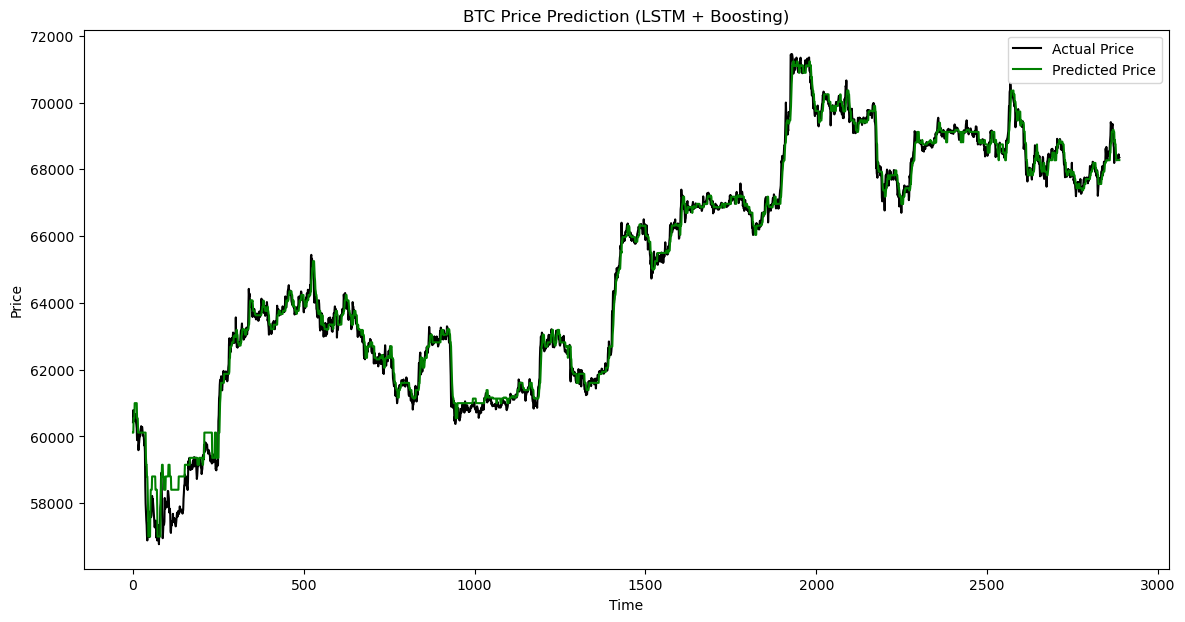

BTC - LSTM Model:
Root Mean Squared Error (RMSE) for BTC: 328.5789292423617
Mean Absolute Error (MAE) for BTC: 214.2563308626203
Mean Absolute Percentage Error (MAPE) for BTC: 0.003373211831790503
R-squared (R²) Score for BTC: 0.9914783767787708
Mean Squared Logarithmic Error (MSLE) for BTC: 2.8182170092923327e-05
Explained Variance Score for BTC: 0.9917110360017609
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Final Balance with LSTM + Boosting Model for BTC: 1102.74 USDT
Total Trades with LSTM + Boosting Model for BTC: 18


ETH LSTM Model:

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0813 - val_loss: 5.5107e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0016 - val_loss: 3.8914e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0014 - val_loss: 4.9955e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0012 - val_loss: 1.8611e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0012 - val_loss: 6.3250e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0011 - val_loss: 1.5166e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0010 - val_loss: 1.3075e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 8.7531e-04 - val_loss: 1.4607e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 8.5315e-04 - val_loss: 2.8886e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 7.3249e-04 - val_loss: 2.6930e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 7.0919e-04 - val_loss: 2.3797e-04
Epoch 12/50
91

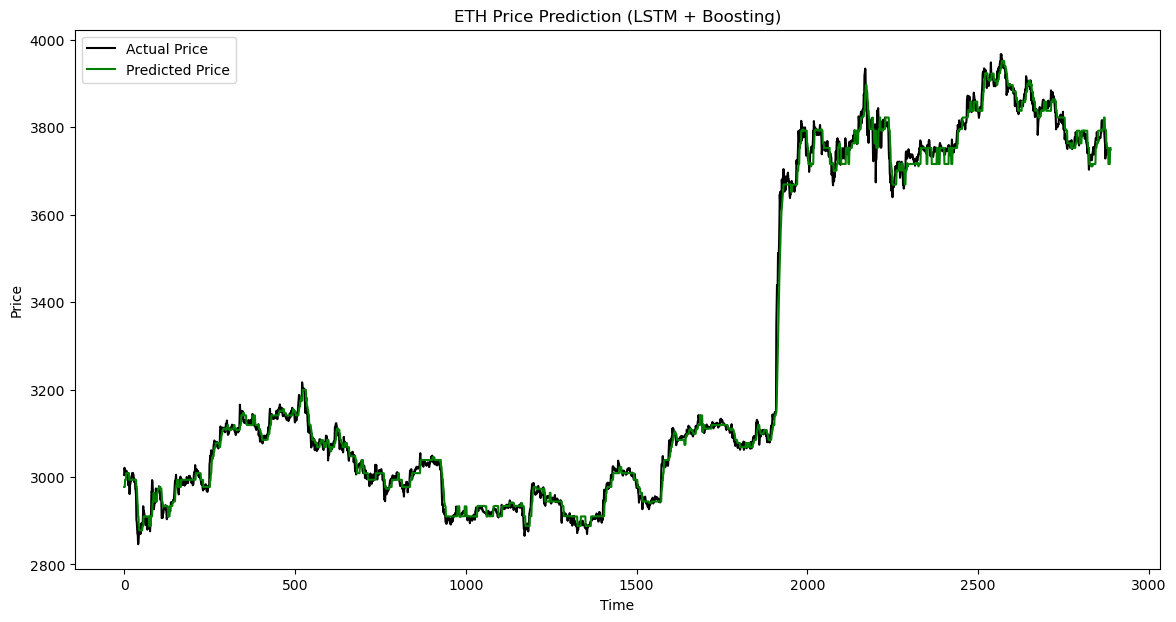

ETH - LSTM Model:
Root Mean Squared Error (RMSE) for ETH: 22.22995993427881
Mean Absolute Error (MAE) for ETH: 14.221464161849298
Mean Absolute Percentage Error (MAPE) for ETH: 0.0042636968735896355
R-squared (R²) Score for ETH: 0.9964438872511883
Mean Squared Logarithmic Error (MSLE) for ETH: 4.33693000580851e-05
Explained Variance Score for ETH: 0.996458054537194
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Final Balance with LSTM + Boosting Model for ETH: 1134.31 USDT
Total Trades with LSTM + Boosting Model for ETH: 12


BNB LSTM Model:

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0617 - val_loss: 7.9327e-05
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0019 - val_loss: 3.0748e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0016 - val_loss: 3.4984e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0013 - val_loss: 5.3777e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0012 - val_loss: 5.5874e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0013 - val_loss: 8.9704e-05
361/361 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


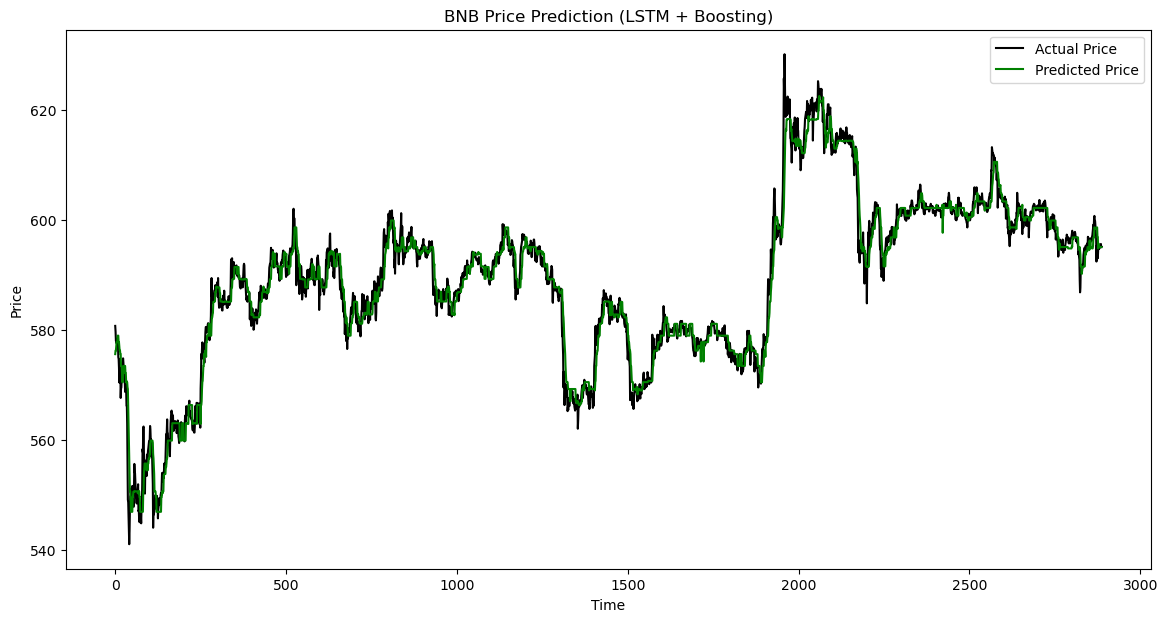

BNB - LSTM Model:
Root Mean Squared Error (RMSE) for BNB: 2.698642292119572
Mean Absolute Error (MAE) for BNB: 1.8175866994970151
Mean Absolute Percentage Error (MAPE) for BNB: 0.0030966598304777012
R-squared (R²) Score for BNB: 0.9678027368226368
Mean Squared Logarithmic Error (MSLE) for BNB: 2.120977541235275e-05
Explained Variance Score for BNB: 0.9678556625283602
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
Final Balance with LSTM + Boosting Model for BNB: 1082.20 USDT
Total Trades with LSTM + Boosting Model for BNB: 10


LTC LSTM Model:

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.0612 - val_loss: 1.1576e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0013 - val_loss: 1.4738e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0012 - val_loss: 4.3770e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0012 - val_loss: 1.0029e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 9.2884e-04 - val_loss: 2.0498e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 8.8499e-04 - val_loss: 7.0226e-05
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 7.3817e-04 - val_loss: 2.3557e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 7.2972e-04 - val_loss: 8.7891e-05
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 6.4315e-04 - val_loss: 5.3265e-05
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 6.0313e-04 - val_loss: 1.3884e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 5.9834e-04 - val_loss: 9.6983e-05
E

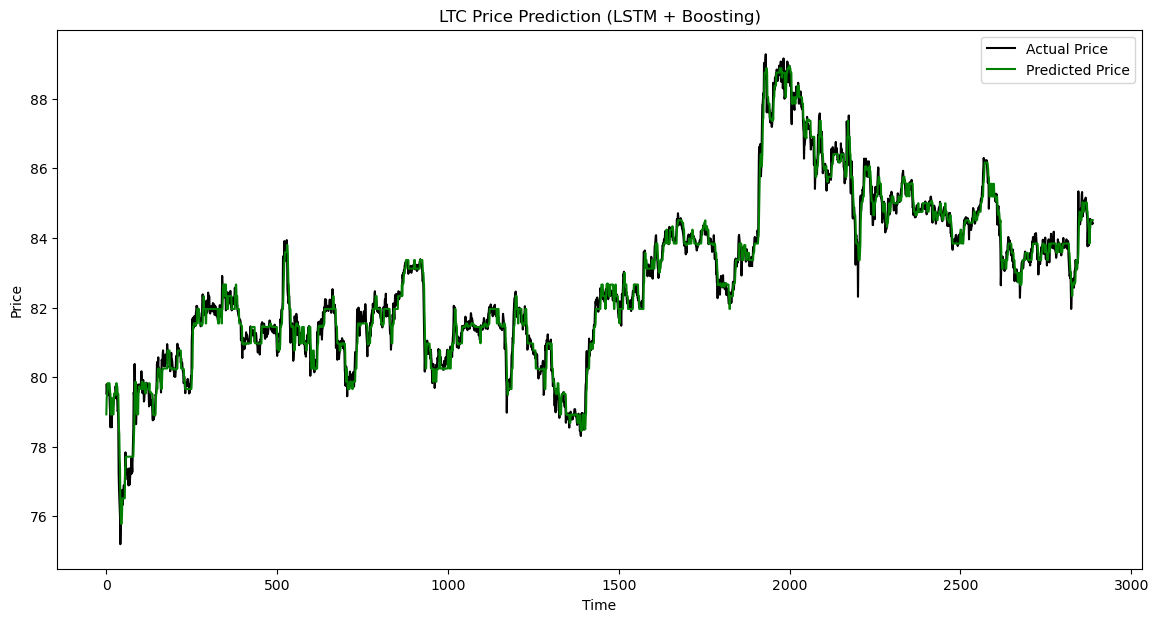

LTC - LSTM Model:
Root Mean Squared Error (RMSE) for LTC: 0.3273690844196396
Mean Absolute Error (MAE) for LTC: 0.2298810304803037
Mean Absolute Percentage Error (MAPE) for LTC: 0.0027858257691079206
R-squared (R²) Score for LTC: 0.9803802245750453
Mean Squared Logarithmic Error (MSLE) for LTC: 1.5454868788679376e-05
Explained Variance Score for LTC: 0.980399340085028
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
Final Balance with LSTM + Boosting Model for LTC: 1088.34 USDT
Total Trades with LSTM + Boosting Model for LTC: 10


XRP LSTM Model:

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0323 - val_loss: 6.5587e-05
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0011 - val_loss: 6.9754e-05
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 9.2824e-04 - val_loss: 1.5719e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 8.0255e-04 - val_loss: 4.5135e-05
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 6.5050e-04 - val_loss: 4.7129e-05
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 6.1884e-04 - val_loss: 4.7657e-05
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 5.5561e-04 - val_loss: 4.2029e-05
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 5.0330e-04 - val_loss: 1.8427e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 4.6977e-04 - val_loss: 1.4715e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 4.4562e-04 - val_loss: 4.6151e-05
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 4.0936e-04 - val_loss: 5.113

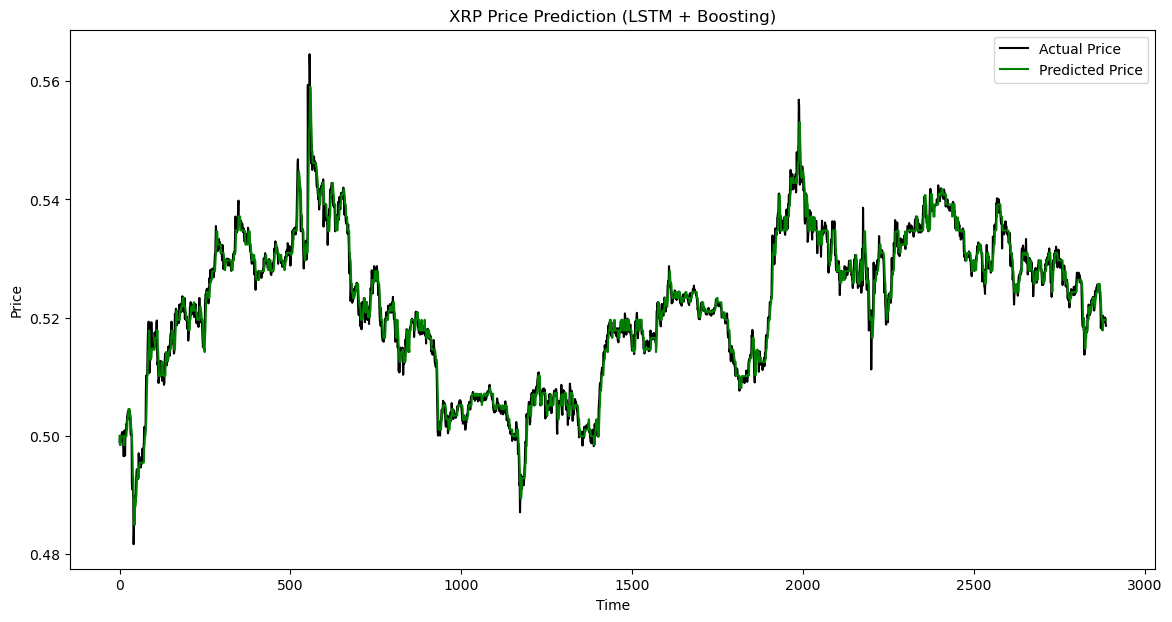

XRP - LSTM Model:
Root Mean Squared Error (RMSE) for XRP: 0.0018517267624687992
Mean Absolute Error (MAE) for XRP: 0.0012568380637347362
Mean Absolute Percentage Error (MAPE) for XRP: 0.002404855527986834
R-squared (R²) Score for XRP: 0.9776397165499772
Mean Squared Logarithmic Error (MSLE) for XRP: 1.4732287117636595e-06
Explained Variance Score for XRP: 0.977640175672788
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Final Balance with LSTM + Boosting Model for XRP: 1290.38 USDT
Total Trades with LSTM + Boosting Model for XRP: 45


In [16]:
for coin, data in datasets.items():
    print(f'\n\n{coin} LSTM Model:\n')
    results['LSTM'][coin] = train_and_evaluate_lstm(data, coin)

## Temporal Convolutional Networks (TCN) Model

In [21]:
# Given that the best Hyperparameters are known
def build_tcn_model(filters_1=64, kernel_size_1=5, filters_2=32, kernel_size_2=5, dense_units=64, learning_rate=0.001):
    seq_len = 60  # Sequence length
    model = Sequential()
    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size_1, activation='relu', input_shape=(seq_len, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=filters_2, kernel_size=kernel_size_2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

### Hyperparameter Tuning

In [17]:
# Hypertuning the TCN model
def params_tcn_model(hp):
    seq_len = 60  # Sequence length
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('conv1d_1_filters', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv1d_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(seq_len, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=hp.Int('conv1d_2_filters', min_value=16, max_value=64, step=16),
                     kernel_size=hp.Choice('conv1d_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

Best performing hyperparameters were found to be:
- Filters in Conv1D layer 1: 64
- Kernel size in Conv1D layer 1: 5
- Filters in Conv1D layer 2: 32
- Kernel size in Conv1D layer 2: 5
- Number of units in Dense layer: 64
- Learning rate: 0.001

### Ensemble Methods

#### Bagging

In [17]:
def train_tcn_models_for_bagging(data, n_models=10):
    seq_len = 60  # Sequence length
    x, y, scaler = preprocess_data(data, 'close', seq_len)

    # Splitting the data into training and test sets
    split = int(0.8 * len(x))
    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]

    models = []
    for i in range(n_models):
        model = build_tcn_model(filters_1=64, kernel_size_1=5, filters_2=32, kernel_size_2=5, dense_units=64, learning_rate=0.001)
        model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))
        models.append(model)
    
    return models, x_test, y_test, scaler

In [18]:
def bagging_predict(models, x, scaler):
    predictions = np.zeros((x.shape[0], 1))
    for model in models:
        predictions += model.predict(x)
    predictions /= len(models)
    return scaler.inverse_transform(predictions)

In [19]:
def bagging_evaluate(data, models, scaler):
    seq_len = 60
    x, y, _ = preprocess_data(data, 'close', seq_len)

    # Split the data into training and test sets
    split = int(0.8 * len(x))
    x_test, y_test = x[split:], y[split:]

    predicted_prices = bagging_predict(models, x_test, scaler)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, color='black', label='Actual Price')
    plt.plot(predicted_prices, color='green', label='Predicted Price')
    plt.title(f'Price Prediction (TCN + Bagging)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    msle = mean_squared_log_error(actual_prices, predicted_prices)
    explained_variance = explained_variance_score(actual_prices, predicted_prices)

    print(f"{coin} - TCN Model:")
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}')
    print(f'R-squared (R²) Score: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
    print(f'Explained Variance Score: {explained_variance}')

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance
    }



BTC - TCN Bagging Model:

Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0217 - val_loss: 3.9140e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7863e-04 - val_loss: 2.4725e-04
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9704e-04 - val_loss: 1.8788e-04
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8161e-04 - val_loss: 2.4176e-04
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5532e-04 - val_loss: 1.4805e-04
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0635e-04 - val_loss: 1.3697e-04
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3920e-04 - val_loss: 2.6326e-04
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2164e-04 - val_loss: 6.1277e-05
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8263e-05 - val_loss: 7.0602e-05
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5561e-04 - val_loss: 5.0969e-05
Epoch 1/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086 - val_l

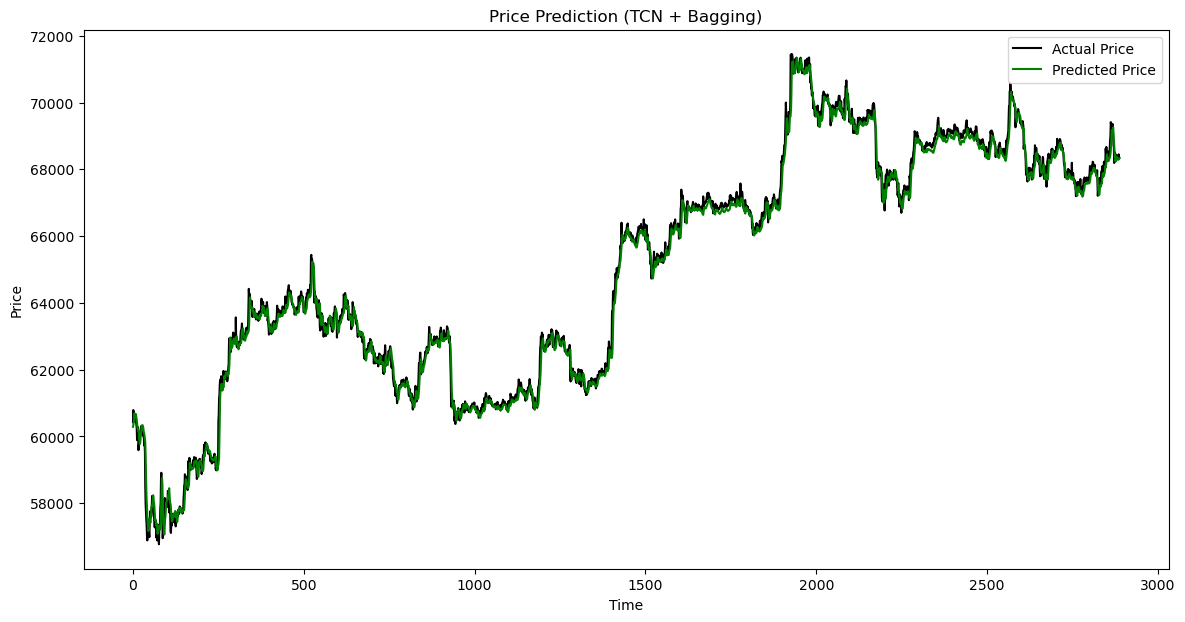

BTC - TCN Model:
Root Mean Squared Error (RMSE): 259.17881886292025
Mean Absolute Error (MAE): 183.24885568163052
Mean Absolute Percentage Error (MAPE): 0.002825896185612781
R-squared (R²) Score: 0.9946979731725043
Mean Squared Logarithmic Error (MSLE): 1.6274528442895847e-05
Explained Variance Score: 0.995392712277068


ETH - TCN Bagging Model:

Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0104 - val_loss: 4.4434e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4010e-04 - val_loss: 4.6193e-04
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1628e-04 - val_loss: 2.2807e-04
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8458e-04 - val_loss: 1.7260e-04
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8828e-04 - val_loss: 3.2165e-04
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3852e-04 - val_loss: 1.1899e-04
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8655e-04 - val_loss: 4.6725e-04
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9387e-04 - val_loss: 1.0481e-04
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3124e-04 - val_loss: 1.0990e-04
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3661e-04 - val_loss: 3.2010e-04
Epoch 1/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0107 - val_l

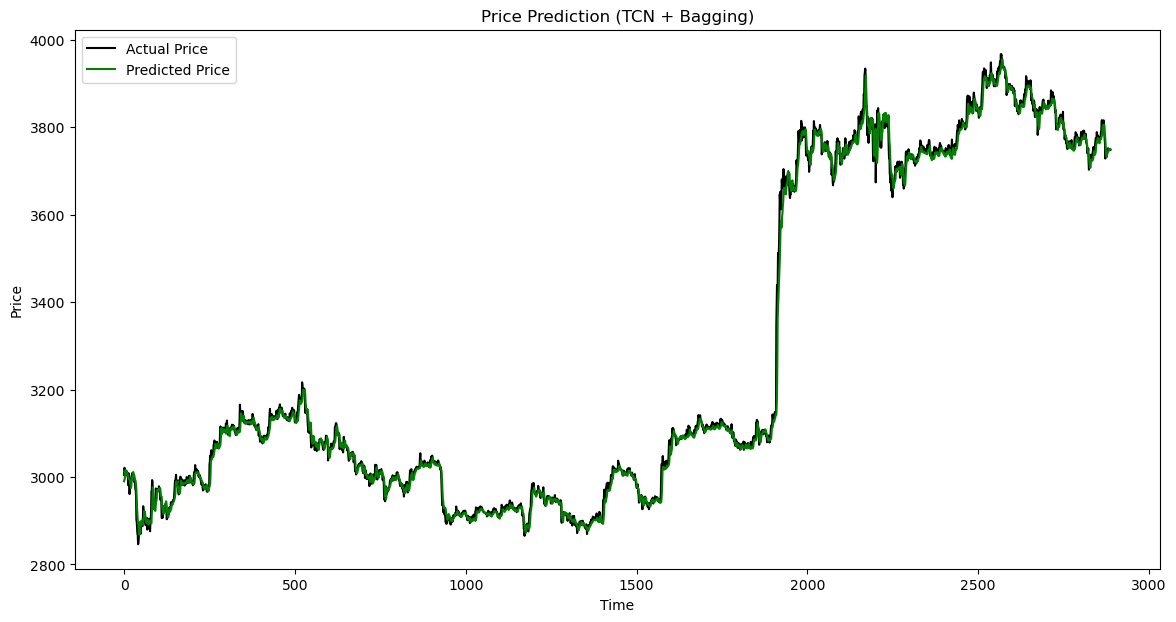

ETH - TCN Model:
Root Mean Squared Error (RMSE): 18.590059758677853
Mean Absolute Error (MAE): 11.086117212724677
Mean Absolute Percentage Error (MAPE): 0.0033291434325440437
R-squared (R²) Score: 0.9975130919172016
Mean Squared Logarithmic Error (MSLE): 3.0392008718487385e-05
Explained Variance Score: 0.9976780081545512


BNB - TCN Bagging Model:

Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0265 - val_loss: 2.4368e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.5178e-04 - val_loss: 2.3453e-04
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6509e-04 - val_loss: 1.6182e-04
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8672e-04 - val_loss: 1.0069e-04
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5031e-04 - val_loss: 3.3451e-04
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4158e-04 - val_loss: 5.9787e-05
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4496e-04 - val_loss: 4.7528e-05
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3092e-04 - val_loss: 5.2828e-05
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1801e-04 - val_loss: 4.3567e-05
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1871e-04 - val_loss: 4.5982e-05
Epoch 1/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0215 - val_l

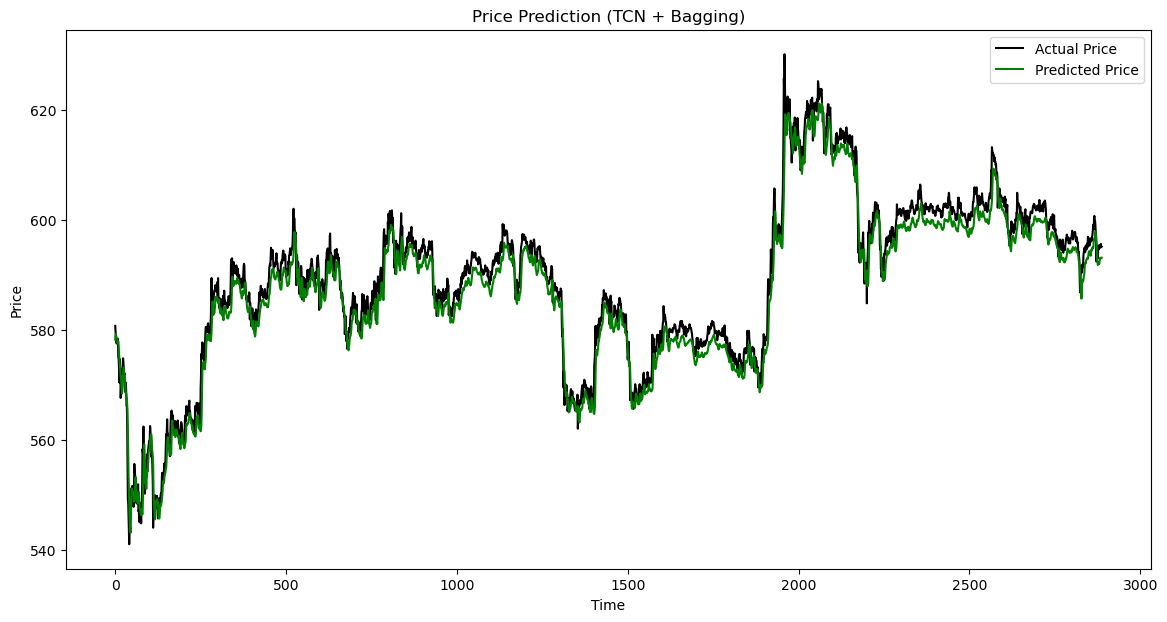

BNB - TCN Model:
Root Mean Squared Error (RMSE): 2.947310272106304
Mean Absolute Error (MAE): 2.426013741494706
Mean Absolute Percentage Error (MAPE): 0.004113810739196787
R-squared (R²) Score: 0.9615956845246787
Mean Squared Logarithmic Error (MSLE): 2.5038106196025863e-05
Explained Variance Score: 0.9802441995540392


LTC - TCN Bagging Model:

Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0053 - val_loss: 2.4060e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6748e-04 - val_loss: 1.1274e-04
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5336e-04 - val_loss: 8.8353e-05
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7614e-04 - val_loss: 8.4735e-05
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8046e-04 - val_loss: 4.9731e-05
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8954e-04 - val_loss: 2.8317e-04
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7522e-04 - val_loss: 4.4178e-05
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4039e-04 - val_loss: 7.8489e-05
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4611e-04 - val_loss: 1.7001e-04
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6651e-04 - val_loss: 3.8341e-05
Epoch 1/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0063 - val_l

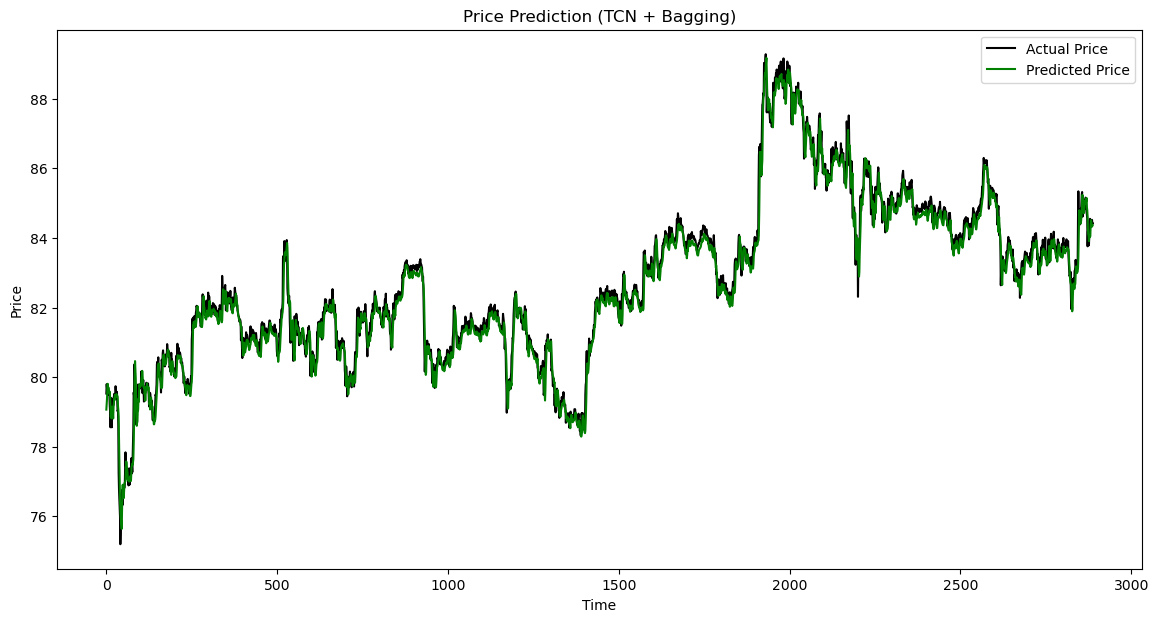

LTC - TCN Model:
Root Mean Squared Error (RMSE): 0.32287351964967037
Mean Absolute Error (MAE): 0.2351854932019565
Mean Absolute Percentage Error (MAPE): 0.0028394913371718273
R-squared (R²) Score: 0.980915378093077
Mean Squared Logarithmic Error (MSLE): 1.4877901309136256e-05
Explained Variance Score: 0.9841133322025373


XRP - TCN Bagging Model:

Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0122 - val_loss: 8.9363e-05
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5771e-04 - val_loss: 6.1288e-05
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6119e-04 - val_loss: 5.3409e-05
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2398e-04 - val_loss: 6.1216e-05
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8448e-04 - val_loss: 6.2986e-05
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9884e-04 - val_loss: 1.0567e-04
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0902e-04 - val_loss: 9.3796e-05
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7575e-04 - val_loss: 5.9660e-05
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7308e-04 - val_loss: 4.2891e-05
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9071e-04 - val_loss: 4.6127e-05
Epoch 1/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0057 - val_l

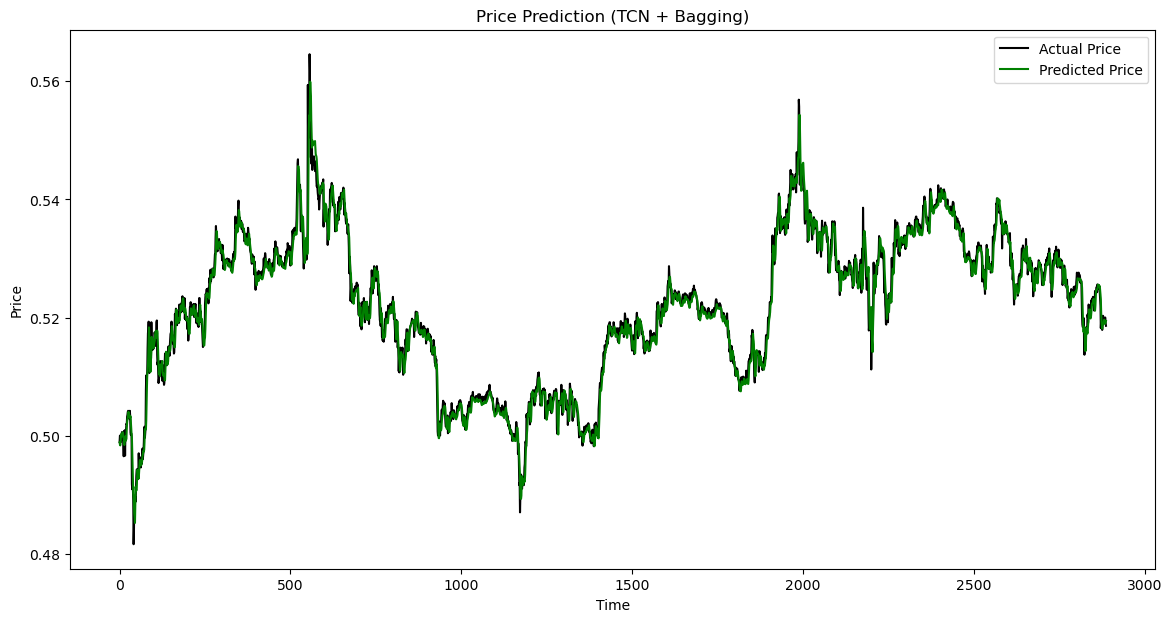

XRP - TCN Model:
Root Mean Squared Error (RMSE): 0.0018394869150753508
Mean Absolute Error (MAE): 0.0012554423852868455
Mean Absolute Percentage Error (MAPE): 0.0024011905145762944
R-squared (R²) Score: 0.9779343409338824
Mean Squared Logarithmic Error (MSLE): 1.4531731606983498e-06
Explained Variance Score: 0.9784727207081362
Bagging Results: {'BTC': {'rmse': 259.17881886292025, 'mae': 183.24885568163052, 'mape': 0.002825896185612781, 'r2': 0.9946979731725043, 'msle': 1.6274528442895847e-05, 'explained_variance': 0.995392712277068}, 'ETH': {'rmse': 18.590059758677853, 'mae': 11.086117212724677, 'mape': 0.0033291434325440437, 'r2': 0.9975130919172016, 'msle': 3.0392008718487385e-05, 'explained_variance': 0.9976780081545512}, 'BNB': {'rmse': 2.947310272106304, 'mae': 2.426013741494706, 'mape': 0.004113810739196787, 'r2': 0.9615956845246787, 'msle': 2.5038106196025863e-05, 'explained_variance': 0.9802441995540392}, 'LTC': {'rmse': 0.32287351964967037, 'mae': 0.2351854932019565, 'mape': 0

In [22]:
# Applying Bagging to each dataset
tcn_bagging_results = {}
for coin, data in datasets.items():
    print(f'\n\n{coin} - TCN Bagging Model:\n')
    models, x_test, y_test, scaler = train_tcn_models_for_bagging(data, n_models=10)
    tcn_bagging_results[coin] = bagging_evaluate(data, models, scaler)

print("Bagging Results:", tcn_bagging_results)

**Bagging Results for the TCN Model:**

| Coin | RMSE          | MAE           | MAPE (%)       | R²            | MSLE            | Explained Variance |
|------|---------------|---------------|----------------|---------------|-----------------|---------------------|
| BTC  | 270.56        | 197.76        | 0.31           | 0.9942        | 0.000018        | 0.9953              |
| ETH  | 18.13         | 11.06         | 0.33           | 0.9976        | 0.000029        | 0.9977              |
| BNB  | 2.40          | 1.80          | 0.31           | 0.9744        | 0.000017        | 0.9805              |
| LTC  | 0.32          | 0.23          | 0.28           | 0.9816        | 0.000014        | 0.9844              |
| XRP  | 0.0018        | 0.0012        | 0.23           | 0.9782        | 0.0000014       | 0.9782              |


#### Boosting

In [23]:
def train_tcn_model_for_boosting(data):
    seq_len = 60  # Sequence length
    x, y, scaler = preprocess_data(data, 'close', seq_len)

    # Split the data into training and test sets
    split = int(0.8 * len(x))
    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]

    model = build_tcn_model(filters_1=64, kernel_size_1=5, filters_2=32, kernel_size_2=5, dense_units=64, learning_rate=0.001)
    model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))
    
    return model, x_train, y_train, x_test, y_test, scaler

In [24]:
def train_boosting_model(tcn_model, x_train, y_train):
    tcn_predictions_train = tcn_model.predict(x_train).flatten()
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    gbr.fit(tcn_predictions_train.reshape(-1, 1), y_train)
    return gbr

In [25]:
def boosting_predict(tcn_model, boosting_model, x, scaler):
    tcn_predictions = tcn_model.predict(x).flatten()
    boosted_predictions = boosting_model.predict(tcn_predictions.reshape(-1, 1))
    return scaler.inverse_transform(boosted_predictions.reshape(-1, 1))

In [26]:
def boosting_evaluate(data, tcn_model, boosting_model, scaler):
    seq_len = 60
    x, y, _ = preprocess_data(data, 'close', seq_len)

    # Split the data into training and test sets
    split = int(0.8 * len(x))
    x_test, y_test = x[split:], y[split:]

    predicted_prices = boosting_predict(tcn_model, boosting_model, x_test, scaler)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, color='black', label='Actual Price')
    plt.plot(predicted_prices, color='green', label='Predicted Price')
    plt.title(f'Price Prediction (TCN + Boosting)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    msle = mean_squared_log_error(actual_prices, predicted_prices)
    explained_variance = explained_variance_score(actual_prices, predicted_prices)

    print(f"{coin} - TCN Boosting Model:")
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}')
    print(f'R-squared (R²) Score: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
    print(f'Explained Variance Score: {explained_variance}')

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance
    }

Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0149 - val_loss: 3.1249e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7034e-04 - val_loss: 1.6264e-04
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1506e-04 - val_loss: 1.0854e-04
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7955e-04 - val_loss: 9.1004e-05
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7901e-04 - val_loss: 2.2276e-04
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5348e-04 - val_loss: 1.5149e-04
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5628e-04 - val_loss: 9.2679e-05
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6272e-04 - val_loss: 1.6193e-04
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2244e-04 - val_loss: 6.1090e-05
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0449e-04 - val_loss: 9.6734e-05
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

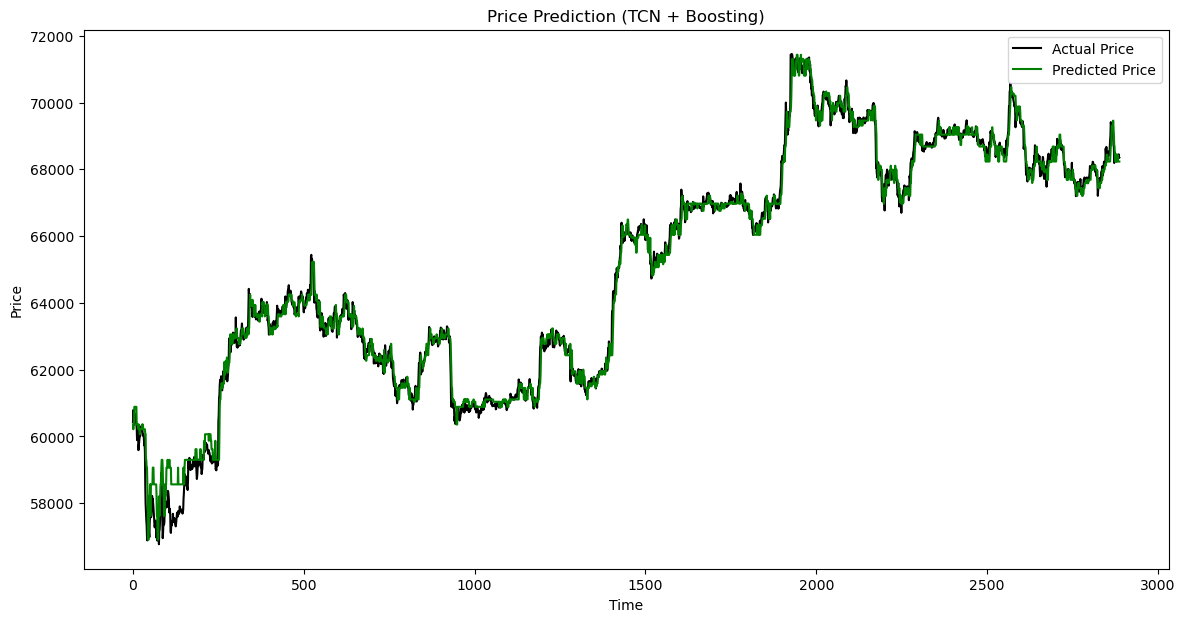

BTC - TCN Boosting Model:
Root Mean Squared Error (RMSE): 334.2392669399368
Mean Absolute Error (MAE): 221.7906524889193
Mean Absolute Percentage Error (MAPE): 0.003484862348213333
R-squared (R²) Score: 0.9911822486428916
Mean Squared Logarithmic Error (MSLE): 2.918034089476026e-05
Explained Variance Score: 0.9912271708311334
Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081 - val_loss: 6.2617e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0755e-04 - val_loss: 4.2438e-04
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7932e-04 - val_loss: 5.4071e-04
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5182e-04 - val_loss: 2.2233e-04
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2790e-04 - val_loss: 1.0077e-04
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1510e-04 - val_loss: 2.1871e-04
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4851e-04 - val_loss: 2.1868e-04
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3354e-04 - val_loss: 1.1949e-04
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3339e-04 - val_loss: 1.4433e-04
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0721e-04 - val_loss: 9.2261e-05
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

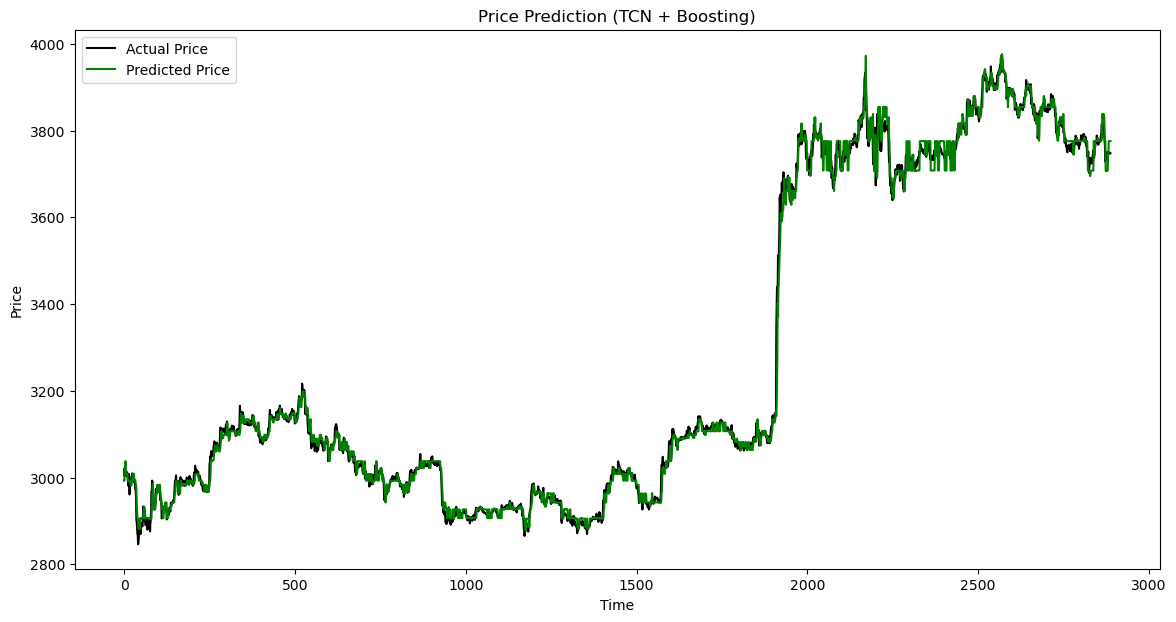

ETH - TCN Boosting Model:
Root Mean Squared Error (RMSE): 20.148186232139903
Mean Absolute Error (MAE): 13.30309336126832
Mean Absolute Percentage Error (MAPE): 0.003975172383647717
R-squared (R²) Score: 0.9970787409215639
Mean Squared Logarithmic Error (MSLE): 3.499129866621014e-05
Explained Variance Score: 0.9970926314148113
Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0137 - val_loss: 2.2956e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5381e-04 - val_loss: 1.4326e-04
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8278e-04 - val_loss: 1.4356e-04
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4212e-04 - val_loss: 2.8611e-04
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9557e-04 - val_loss: 1.3652e-04
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4302e-04 - val_loss: 2.4775e-04
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6625e-04 - val_loss: 8.7085e-05
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3934e-04 - val_loss: 4.4259e-04
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2851e-04 - val_loss: 4.5434e-05
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6521e-04 - val_loss: 4.5698e-05
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

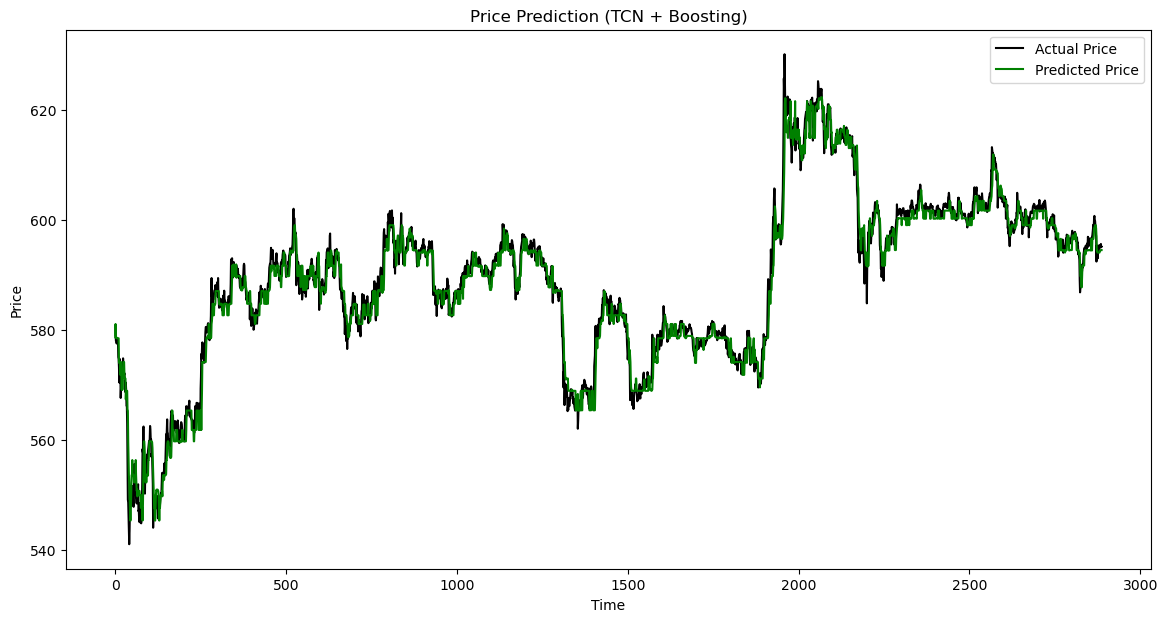

BNB - TCN Boosting Model:
Root Mean Squared Error (RMSE): 2.453617815401569
Mean Absolute Error (MAE): 1.7190409669876154
Mean Absolute Percentage Error (MAPE): 0.002928734636888447
R-squared (R²) Score: 0.973384039348316
Mean Squared Logarithmic Error (MSLE): 1.7561653695439772e-05
Explained Variance Score: 0.9746876270075395
Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0145 - val_loss: 1.2655e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8696e-04 - val_loss: 7.5016e-05
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7887e-04 - val_loss: 5.9116e-05
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3464e-04 - val_loss: 5.2023e-05
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0317e-04 - val_loss: 4.8314e-05
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9904e-04 - val_loss: 8.4905e-05
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0271e-04 - val_loss: 4.9066e-05
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0454e-04 - val_loss: 4.4267e-05
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6335e-04 - val_loss: 5.7191e-05
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5298e-04 - val_loss: 4.6965e-05
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

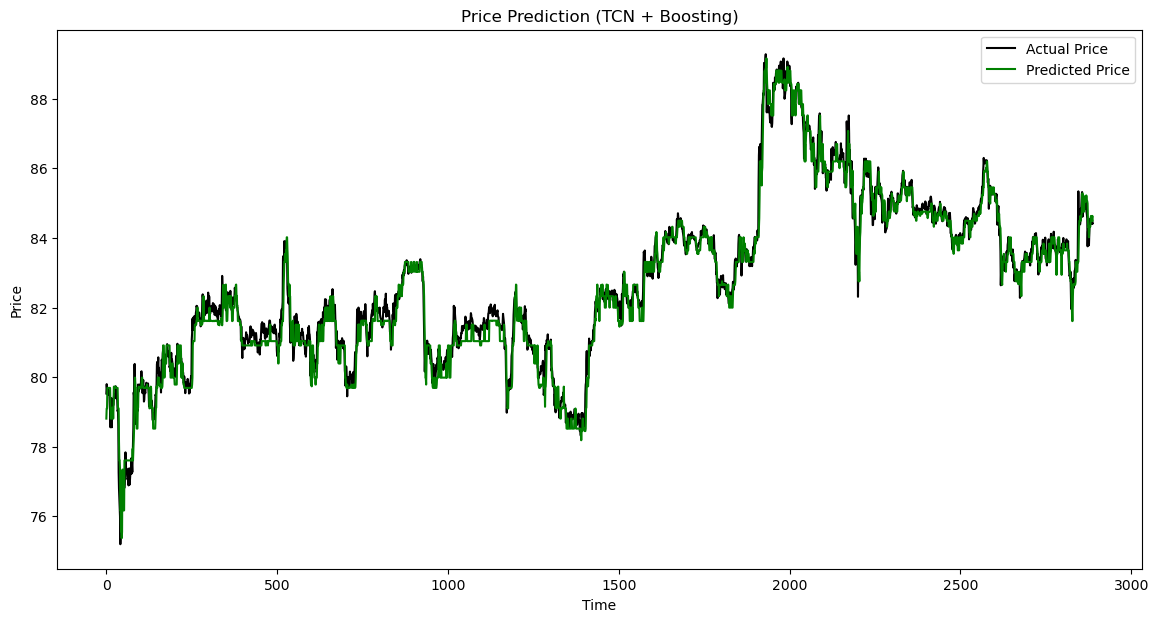

LTC - TCN Boosting Model:
Root Mean Squared Error (RMSE): 0.3778596996397181
Mean Absolute Error (MAE): 0.27991983145286947
Mean Absolute Percentage Error (MAPE): 0.003394109960986398
R-squared (R²) Score: 0.9738615485587228
Mean Squared Logarithmic Error (MSLE): 2.0627416454506582e-05
Explained Variance Score: 0.9768740966490708
Epoch 1/10


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085 - val_loss: 1.6691e-04
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7611e-04 - val_loss: 1.6057e-04
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0514e-04 - val_loss: 8.0750e-05
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8470e-04 - val_loss: 8.7192e-05
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7031e-04 - val_loss: 4.7825e-05
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1424e-04 - val_loss: 5.3714e-05
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9387e-04 - val_loss: 4.5112e-05
Epoch 8/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0793e-04 - val_loss: 4.4965e-05
Epoch 9/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1643e-04 - val_loss: 4.9376e-05
Epoch 10/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6913e-04 - val_loss: 4.3135e-05
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

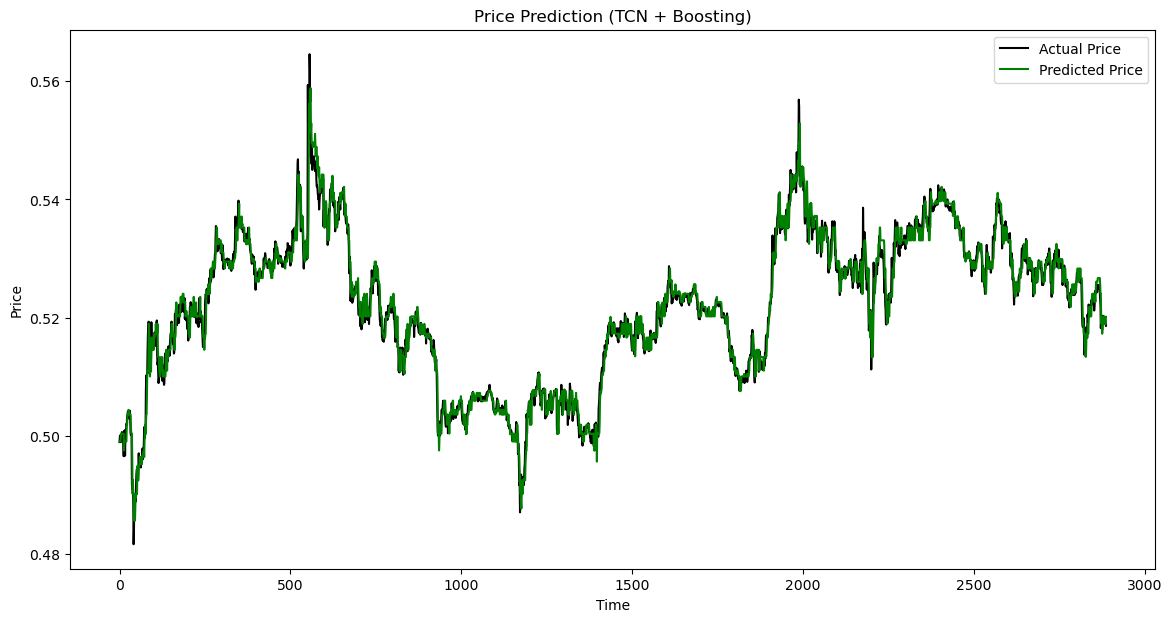

XRP - TCN Boosting Model:
Root Mean Squared Error (RMSE): 0.002052035928472155
Mean Absolute Error (MAE): 0.0013985545578604033
Mean Absolute Percentage Error (MAPE): 0.0026735358914096214
R-squared (R²) Score: 0.9725404498162126
Mean Squared Logarithmic Error (MSLE): 1.8075846680283541e-06
Explained Variance Score: 0.9725601789243274
Boosting Results: {'BTC': {'rmse': 334.2392669399368, 'mae': 221.7906524889193, 'mape': 0.003484862348213333, 'r2': 0.9911822486428916, 'msle': 2.918034089476026e-05, 'explained_variance': 0.9912271708311334}, 'ETH': {'rmse': 20.148186232139903, 'mae': 13.30309336126832, 'mape': 0.003975172383647717, 'r2': 0.9970787409215639, 'msle': 3.499129866621014e-05, 'explained_variance': 0.9970926314148113}, 'BNB': {'rmse': 2.453617815401569, 'mae': 1.7190409669876154, 'mape': 0.002928734636888447, 'r2': 0.973384039348316, 'msle': 1.7561653695439772e-05, 'explained_variance': 0.9746876270075395}, 'LTC': {'rmse': 0.3778596996397181, 'mae': 0.27991983145286947, 'mape

In [27]:
# Apply Boosting LSTM to each dataset
tcn_boosting_results = {}
for coin, data in datasets.items():
    tcn_model, x_train, y_train, x_test, y_test, scaler = train_tcn_model_for_boosting(data)
    boosting_model = train_boosting_model(tcn_model, x_train, y_train)
    tcn_boosting_results[coin] = boosting_evaluate(data, tcn_model, boosting_model, scaler)

print("Boosting Results:", tcn_boosting_results)

**Boosting Results for the TCN Model:**

| Coin | RMSE          | MAE           | MAPE (%)       | R²            | MSLE            | Explained Variance |
|------|---------------|---------------|----------------|---------------|-----------------|---------------------|
| BTC  | 410.30        | 268.58        | 0.42           | 0.9867        | 0.000043        | 0.9868              |
| ETH  | 19.90         | 12.48         | 0.38           | 0.9971        | 0.000035        | 0.9972              |
| BNB  | 2.39          | 1.70          | 0.29           | 0.9747        | 0.000017        | 0.9762              |
| LTC  | 0.35          | 0.25          | 0.30           | 0.9780        | 0.000017        | 0.9790              |
| XRP  | 0.0019        | 0.0013        | 0.25           | 0.9751        | 0.0000016       | 0.9751              |


**Analysis**
- *RMSE & MAE*: Bagging generally performs better for BTC and LTC in terms of RMSE and MAE.
Boosting performs better for ETH and has a comparable performance for BNB and XRP.
- *MAPE*: Bagging has lower MAPE for BTC and LTC. Boosting has lower MAPE for ETH, BNB, and XRP.
- *R² & Explained Variance*: Bagging shows slightly higher R² and explained variance for BTC and ETH. Boosting shows better R² and explained variance for BNB, LTC, and XRP.
- *MSLE*: Bagging has a lower MSLE for BTC, ETH, LTC, and XRP. Boosting has a lower MSLE for BNB.

Therefore; 
- *Bagging*: Generally better for BTC and LTC. Better at minimizing large errors (lower RMSE and MAE) for these coins. Slightly better variance explanation for BTC and ETH.
- *Boosting*: Better for ETH, BNB, and XRP. Minimizes percentage errors effectively (lower MAPE for these coins). Slightly better variance explanation for BNB, LTC, and XRP.

### Training & Evaluation

In [28]:
# Function to train and evaluate the TCN model
def train_and_evaluate_tcn(data, coin):
    start_time = time.time()  # For keeping track of time taken to run the model
    
    seq_len = 60  # Sequence length
    x, y, scaler = preprocess_data(data, 'close', seq_len)

    # Split the data into training, validation, and test sets
    split = int(0.8 * len(x))
    x_train, x_val, x_test = x[:split], x[split:], x[split:]
    y_train, y_val, y_test = y[:split], y[split:], y[split:]

    # # For Hyperparameter Tuning (uncomment code to resetup for Hyperparameter Tuning):
    # tuner = RandomSearch(
    #     params_tcn_model,
    #     objective='val_loss',
    #     max_trials=10,
    #     executions_per_trial=5,
    #     directory='tcn_tuner',
    #     project_name='tcn_hyperparameters'
    # )
    # tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test))
    # best_model = tuner.get_best_models(num_models=1)[0]
    # print("Best Model:", best_model)

    # Given that the best hyperparameters are known
    # Comment these two lines, and uncomment the above tuner, to resetup for Hyperparameter Tuning
    best_model = build_tcn_model(filters_1=64, kernel_size_1=5, filters_2=32, kernel_size_2=5, dense_units=64, learning_rate=0.001)

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    best_model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val), callbacks=[early_stopping])

    # Making predictions
    predicted_prices = best_model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, color='black', label='Actual Price')
    plt.plot(predicted_prices, color='green', label='Predicted Price')
    plt.title(f'{coin} Price Prediction (TCN)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    msle = mean_squared_log_error(actual_prices, predicted_prices)
    explained_variance = explained_variance_score(actual_prices, predicted_prices)
    
    print(f'Root Mean Squared Error (RMSE) for {coin}: {rmse}')
    print(f'Mean Absolute Error (MAE) for {coin}: {mae}')
    print(f'Mean Absolute Percentage Error (MAPE) for {coin}: {mape}')
    print(f'R-squared (R²) Score for {coin}: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE) for {coin}: {msle}')
    print(f'Explained Variance Score for {coin}: {explained_variance}')

    # Trading simulation
    final_balance, total_trades, correct_trades, incorrect_trades, annualised_return, sharpe_ratio, max_drawdown, win_ratio = simulate_trading(best_model, data, scaler, initial_capital, trading_fee, seq_len)

    print(f'Final Balance with TCN Model for {coin}: {final_balance:.2f} USDT')
    print(f'Total Trades with TCN Model for {coin}: {total_trades}')

    # # For Hyperparameter Tuning (uncomment code to resetup for Hyperparameter Tuning):
    # # Get the best hyperparameters
    # best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    # print("\nBest performing hyperparameters:")
    # print(f"Filters in Conv1D layer 1: {best_hps.get('conv1d_1_filters')}")
    # print(f"Kernel size in Conv1D layer 1: {best_hps.get('conv1d_1_kernel')}")
    # print(f"Filters in Conv1D layer 2: {best_hps.get('conv1d_2_filters')}")
    # print(f"Kernel size in Conv1D layer 2: {best_hps.get('conv1d_2_kernel')}")
    # print(f"Number of units in Dense layer: {best_hps.get('dense_units')}")
    # print(f"Learning rate: {best_hps.get('learning_rate')}")

    end_time = time.time()  # Stop time
    time_taken = end_time - start_time  # Calculating the elapsed time

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance,
        'final_balance': final_balance,
        'total_trades': total_trades,
        'time_taken': time_taken,
        'correct_trades': correct_trades,
        'incorrect_trades': incorrect_trades,
        'annualised_return': annualised_return, 
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_ratio': win_ratio
    }



BTC - TCN Model

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0406 - val_loss: 5.8626e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9827e-04 - val_loss: 4.5834e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4928e-04 - val_loss: 5.8330e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5901e-04 - val_loss: 3.8884e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5534e-04 - val_loss: 2.5123e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9478e-04 - val_loss: 2.0315e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7146e-04 - val_loss: 1.9210e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2140e-04 - val_loss: 1.5707e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2730e-04 - val_loss: 1.4198e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6919e-04 - val_loss: 1.8898e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0416e-04 - val_loss: 1.1865e-04
E

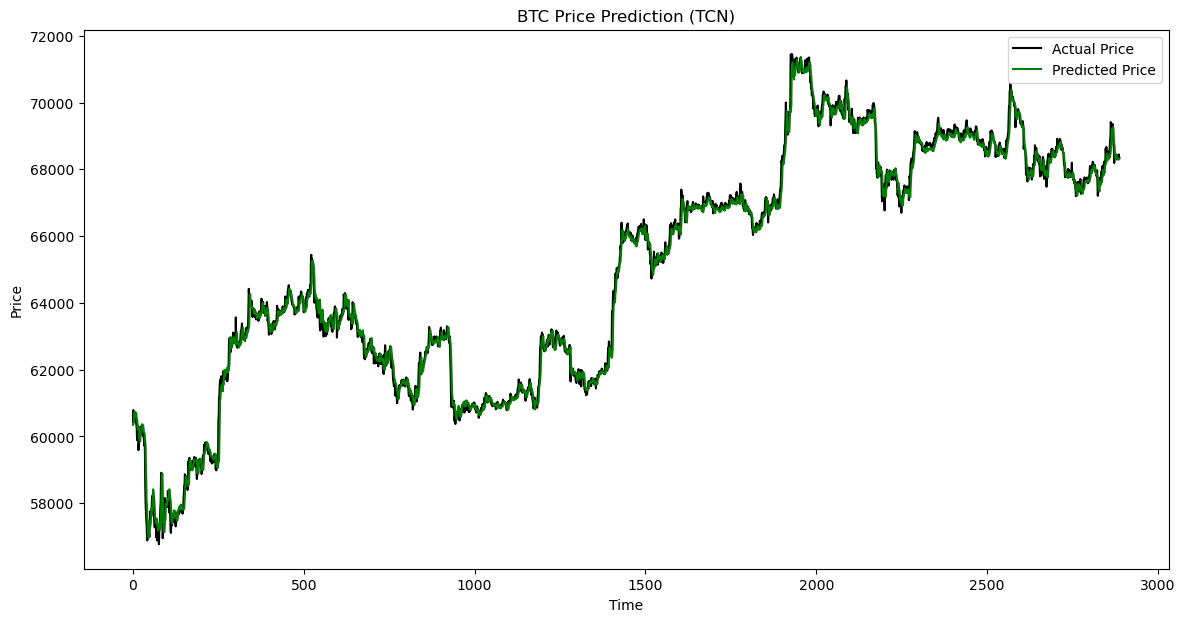

Root Mean Squared Error (RMSE) for BTC: 261.07502521484935
Mean Absolute Error (MAE) for BTC: 176.85041372706027
Mean Absolute Percentage Error (MAPE) for BTC: 0.002737672709654762
R-squared (R²) Score for BTC: 0.9946201079008593
Mean Squared Logarithmic Error (MSLE) for BTC: 1.6719842250967677e-05
Explained Variance Score for BTC: 0.9947442362825557
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final Balance with TCN Model for BTC: 1102.49 USDT
Total Trades with TCN Model for BTC: 18


ETH - TCN Model

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0188 - val_loss: 7.1380e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3855e-04 - val_loss: 6.9046e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2640e-04 - val_loss: 5.3231e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4219e-04 - val_loss: 0.0010
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5121e-04 - val_loss: 2.5902e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4631e-04 - val_loss: 1.3549e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2413e-04 - val_loss: 1.1543e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0823e-04 - val_loss: 1.3659e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0443e-04 - val_loss: 1.0881e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4077e-05 - val_loss: 9.7376e-05
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4453e-05 - val_loss: 1.0547e-04
Epoch

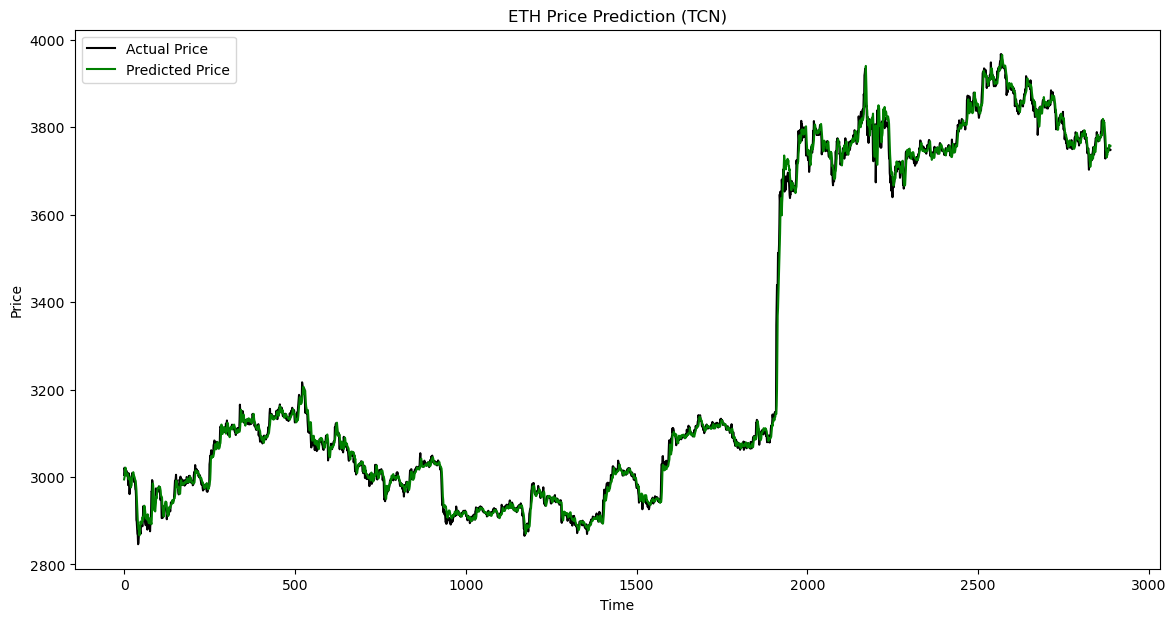

Root Mean Squared Error (RMSE) for ETH: 18.104523491134838
Mean Absolute Error (MAE) for ETH: 10.928006101486757
Mean Absolute Percentage Error (MAPE) for ETH: 0.0032882537063207073
R-squared (R²) Score for ETH: 0.9976413018868275
Mean Squared Logarithmic Error (MSLE) for ETH: 2.892561476817437e-05
Explained Variance Score for ETH: 0.9976434674714526
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final Balance with TCN Model for ETH: 1128.44 USDT
Total Trades with TCN Model for ETH: 18


BNB - TCN Model

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0468 - val_loss: 4.9695e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8238e-04 - val_loss: 3.4663e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0199e-04 - val_loss: 3.9660e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4015e-04 - val_loss: 1.7191e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9080e-04 - val_loss: 2.8359e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7373e-04 - val_loss: 1.8752e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1383e-04 - val_loss: 2.2538e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0321e-04 - val_loss: 8.7162e-05
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3294e-04 - val_loss: 6.7894e-05
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1962e-04 - val_loss: 5.5315e-05
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0462e-04 - val_loss: 6.6650e-05
E

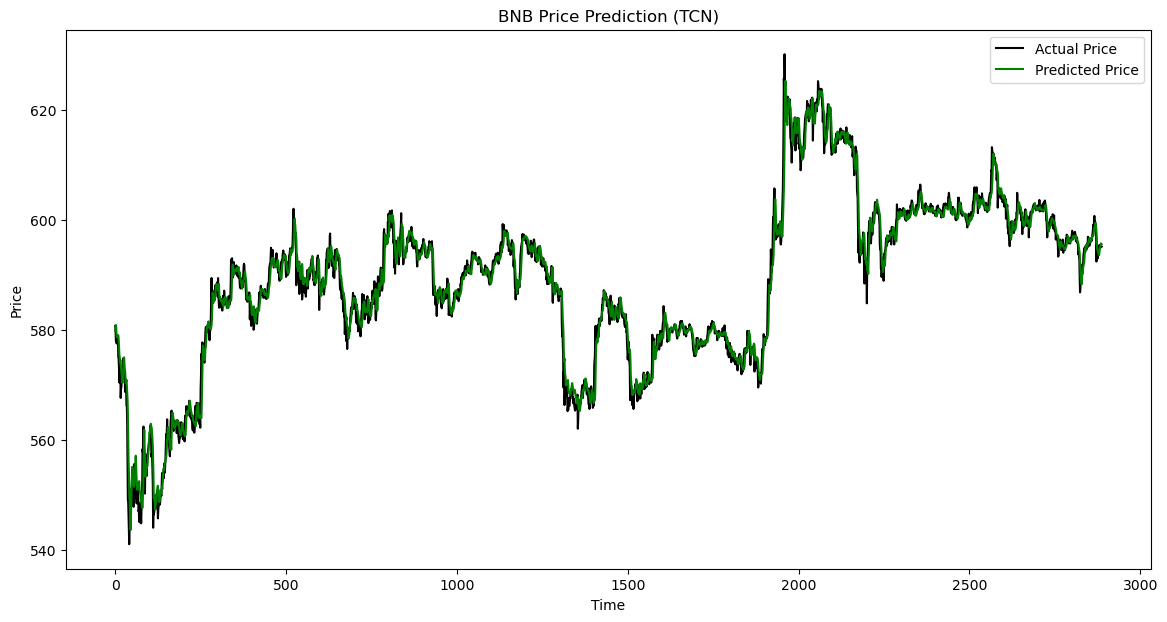

Root Mean Squared Error (RMSE) for BNB: 2.267123652013194
Mean Absolute Error (MAE) for BNB: 1.504074743381829
Mean Absolute Percentage Error (MAPE) for BNB: 0.0025648428583918553
R-squared (R²) Score for BNB: 0.9772763166574039
Mean Squared Logarithmic Error (MSLE) for BNB: 1.5004652361543294e-05
Explained Variance Score for BNB: 0.9773174709083409
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final Balance with TCN Model for BNB: 1226.19 USDT
Total Trades with TCN Model for BNB: 30


LTC - TCN Model

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0255 - val_loss: 2.8330e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8710e-04 - val_loss: 2.0270e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3877e-04 - val_loss: 1.1845e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4063e-04 - val_loss: 9.9232e-05
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6413e-04 - val_loss: 9.9978e-05
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3506e-04 - val_loss: 6.7581e-05
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0744e-04 - val_loss: 9.7918e-05
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1979e-04 - val_loss: 2.4389e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0723e-04 - val_loss: 5.3998e-05
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9191e-04 - val_loss: 6.7246e-05
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7428e-04 - val_loss: 1.4918e-04
E

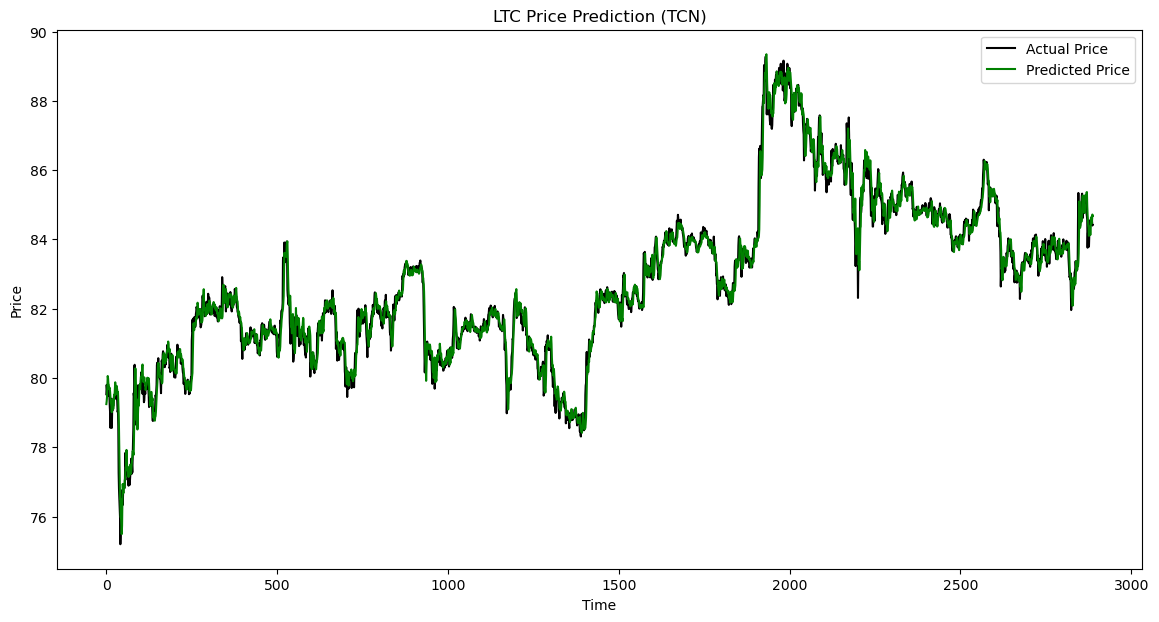

Root Mean Squared Error (RMSE) for LTC: 0.33943958533497215
Mean Absolute Error (MAE) for LTC: 0.2329845839524203
Mean Absolute Percentage Error (MAPE) for LTC: 0.0028163558851280208
R-squared (R²) Score for LTC: 0.9789067412156001
Mean Squared Logarithmic Error (MSLE) for LTC: 1.644987895161162e-05
Explained Variance Score for LTC: 0.9789083040347636
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final Balance with TCN Model for LTC: 1151.60 USDT
Total Trades with TCN Model for LTC: 14


XRP - TCN Model

Epoch 1/50


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0543 - val_loss: 2.8012e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9277e-04 - val_loss: 1.8831e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5900e-04 - val_loss: 1.0146e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8078e-04 - val_loss: 9.7929e-05
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3189e-04 - val_loss: 8.5897e-05
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8334e-04 - val_loss: 6.7854e-05
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5658e-04 - val_loss: 6.2301e-05
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1168e-04 - val_loss: 1.0537e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2758e-04 - val_loss: 7.6056e-05
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0397e-04 - val_loss: 6.0653e-05
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1871e-04 - val_loss: 6.2269e-05
E

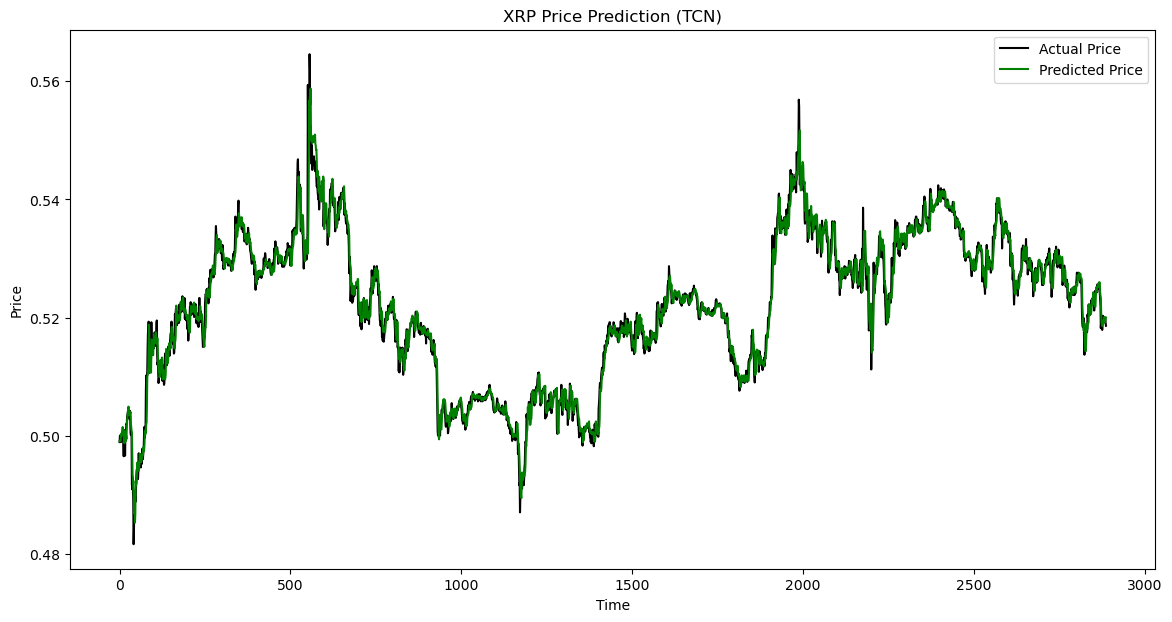

Root Mean Squared Error (RMSE) for XRP: 0.0019193554934173228
Mean Absolute Error (MAE) for XRP: 0.0012678353772103952
Mean Absolute Percentage Error (MAPE) for XRP: 0.0024240411524268845
R-squared (R²) Score for XRP: 0.9759766074444588
Mean Squared Logarithmic Error (MSLE) for XRP: 1.5811218655028657e-06
Explained Variance Score for XRP: 0.9759859986284528
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final Balance with TCN Model for XRP: 1330.55 USDT
Total Trades with TCN Model for XRP: 47


In [29]:
# Training and evaluating the TCN model per coin
for coin, data in datasets.items():
    print(f'\n\n{coin} - TCN Model\n')
    results['TCN'][coin] = train_and_evaluate_tcn(data, coin)

#### Training & Evaluation with Bagging Method

In [45]:
def train_tcn_bagging(data, num_models, coin):
    seq_len = 60  # Sequence length
    x, y, scaler = preprocess_data(data, 'close', seq_len)
    num_samples = len(x)

    # Initialize a list to store trained models and their simulation results
    tcn_models = []
    simulation_results = []

    for i in range(num_models):
        # Randomly select indices for training data with replacement (for bagging)
        indices = random.choices(range(num_samples), k=num_samples)
        x_train, y_train = x[indices], y[indices]

        # Build and train the TCN model
        tcn_model = build_tcn_model(filters_1=64, kernel_size_1=5, filters_2=32, kernel_size_2=5, dense_units=64, learning_rate=0.001)

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        tcn_model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping], verbose=0)

        tcn_models.append(tcn_model)

        # Trading simulation
        final_balance, total_trades, correct_trades, incorrect_trades, annualised_return, sharpe_ratio, max_drawdown, win_ratio = simulate_trading(tcn_model, data, scaler, initial_capital, trading_fee, seq_len)

        # Store the results
        simulation_results.append({
            'final_balance': final_balance,
            'total_trades': total_trades,
            'correct_trades': correct_trades,
            'incorrect_trades': incorrect_trades,
            'annualised_return': annualised_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_ratio': win_ratio
        })
        
    return tcn_models, simulation_results

In [47]:
# Function to make predictions using ensemble of TCN models
def predict_tcn_bagging(models, x_test, scaler):
    # Make predictions using each TCN model
    predictions = [model.predict(x_test) for model in models]
    
    # Aggregate predictions from all TCN models
    ensemble_prediction = np.mean(predictions, axis=0)

    # Inverse transform the predictions
    ensemble_prediction = scaler.inverse_transform(ensemble_prediction)
    
    return ensemble_prediction

In [48]:
# Function to train and evaluate the ensemble of TCN models
def train_and_evaluate_tcn_bagging(data, coin, num_models=5):
    # Train TCN models with bagging and collect simulation results
    tcn_models, simulation_results = train_tcn_bagging(data, num_models, coin)

    start_time = time.time()  # For keeping track of time taken to run the model
    
    seq_len = 60  # Sequence length
    x, y, scaler = preprocess_data(data, 'close', seq_len)

    # Split the data into training, validation, and test sets
    split = int(0.8 * len(x))
    x_train, x_val, x_test = x[:split], x[split:], x[split:]
    y_train, y_val, y_test = y[:split], y[split:], y[split:]

    # Making predictions using the ensemble of TCN models
    predicted_prices = predict_tcn_bagging(tcn_models, x_test, scaler)

    # Actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, color='black', label='Actual Price')
    plt.plot(predicted_prices, color='green', label='Predicted Price')
    plt.title(f'{coin} Price Prediction (TCN Ensemble)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    msle = mean_squared_log_error(actual_prices, predicted_prices)
    explained_variance = explained_variance_score(actual_prices, predicted_prices)
    
    print(f'Root Mean Squared Error (RMSE) for {coin}: {rmse}')
    print(f'Mean Absolute Error (MAE) for {coin}: {mae}')
    print(f'Mean Absolute Percentage Error (MAPE) for {coin}: {mape}')
    print(f'R-squared (R²) Score for {coin}: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE) for {coin}: {msle}')
    print(f'Explained Variance Score for {coin}: {explained_variance}')

    end_time = time.time()  # Stop time
    time_taken = end_time - start_time  # Calculating the elapsed time

    # Aggregate simulation results
    aggregated_results = {
        'final_balance': np.mean([result['final_balance'] for result in simulation_results]),
        'total_trades': np.mean([result['total_trades'] for result in simulation_results]),
        'correct_trades': np.mean([result['correct_trades'] for result in simulation_results]),
        'incorrect_trades': np.mean([result['incorrect_trades'] for result in simulation_results]),
        'annualised_return': np.mean([result['annualised_return'] for result in simulation_results]),
        'sharpe_ratio': np.mean([result['sharpe_ratio'] for result in simulation_results]),
        'max_drawdown': np.mean([result['max_drawdown'] for result in simulation_results]),
        'win_ratio': np.mean([result['win_ratio'] for result in simulation_results])
    }

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance,
        'time_taken': time_taken,
        **aggregated_results  # Include aggregated simulation results
    }



BTC - TCN Ensemble Model



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


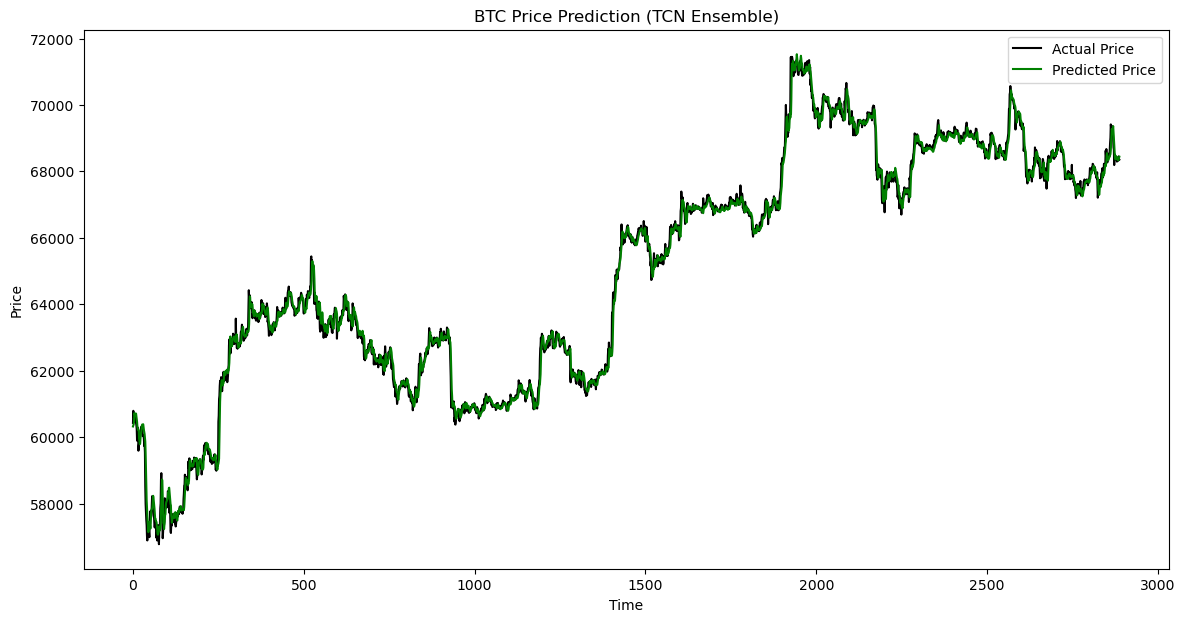

Root Mean Squared Error (RMSE) for BTC: 239.54186904142867
Mean Absolute Error (MAE) for BTC: 159.7640500562674
Mean Absolute Percentage Error (MAPE) for BTC: 0.0024754632955189086
R-squared (R²) Score for BTC: 0.995470963967962
Mean Squared Logarithmic Error (MSLE) for BTC: 1.4077388735624141e-05
Explained Variance Score for BTC: 0.995485003919926


ETH - TCN Ensemble Model



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


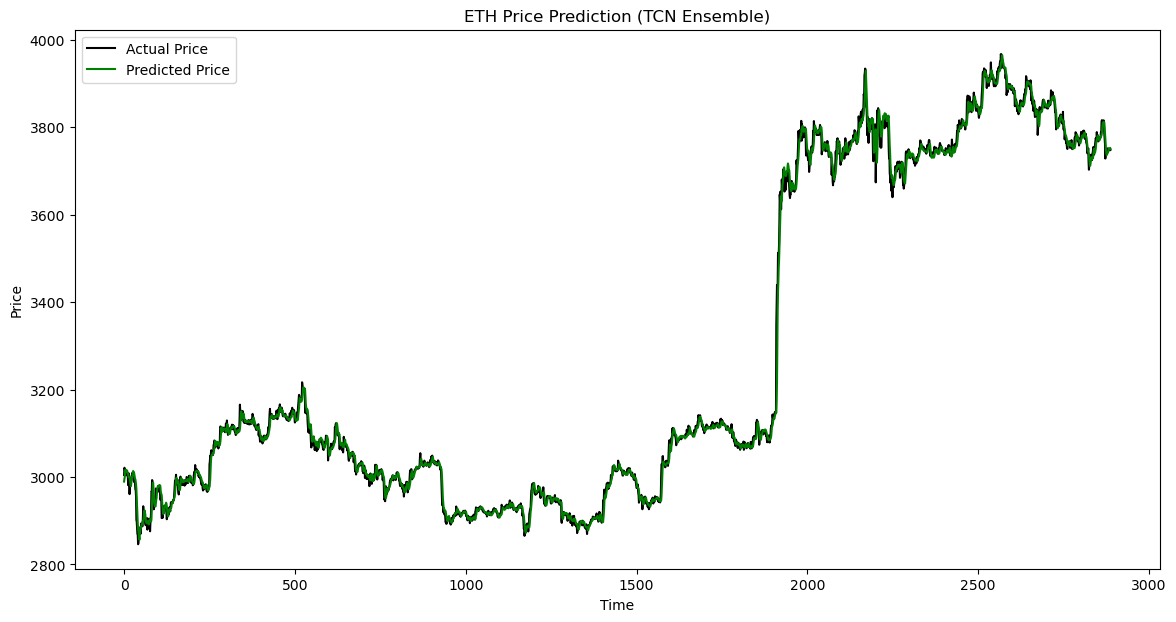

Root Mean Squared Error (RMSE) for ETH: 16.353867015406955
Mean Absolute Error (MAE) for ETH: 9.834566552328601
Mean Absolute Percentage Error (MAPE) for ETH: 0.0029581685980836557
R-squared (R²) Score for ETH: 0.9980754061842748
Mean Squared Logarithmic Error (MSLE) for ETH: 2.363014038565145e-05
Explained Variance Score for ETH: 0.9980796922604082


BNB - TCN Ensemble Model



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


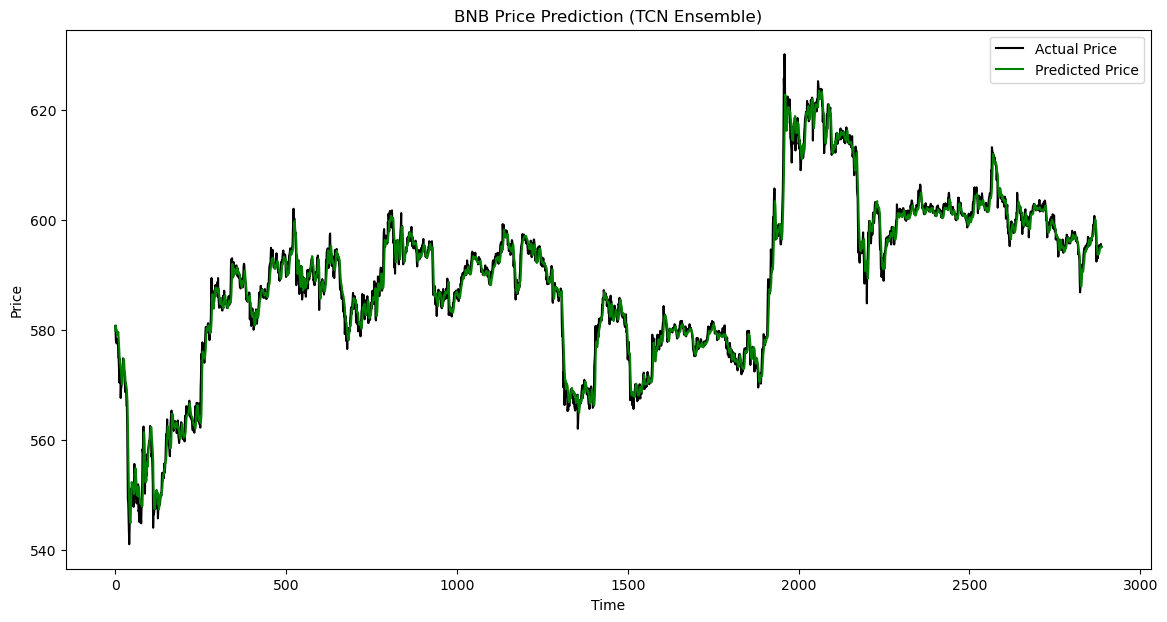

Root Mean Squared Error (RMSE) for BNB: 2.0351224183334984
Mean Absolute Error (MAE) for BNB: 1.3618708010855816
Mean Absolute Percentage Error (MAPE) for BNB: 0.0023204596977728265
R-squared (R²) Score for BNB: 0.9816891126895048
Mean Squared Logarithmic Error (MSLE) for BNB: 1.2063187265402862e-05
Explained Variance Score for BNB: 0.9817883718674965


LTC - TCN Ensemble Model



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


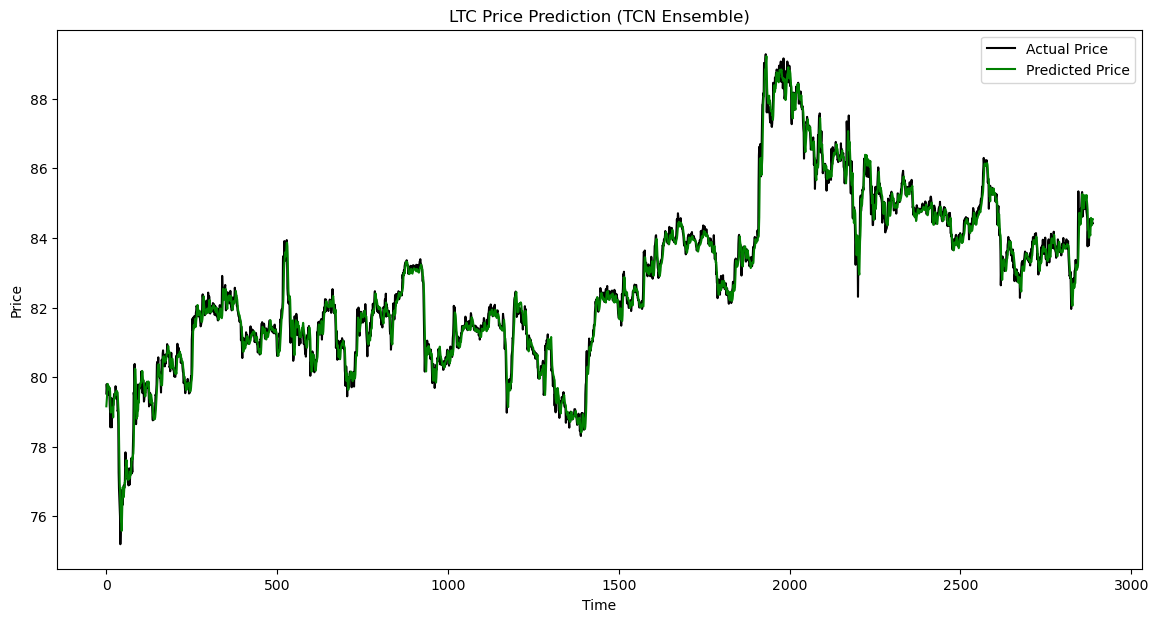

Root Mean Squared Error (RMSE) for LTC: 0.3077004079458886
Mean Absolute Error (MAE) for LTC: 0.2123133657777739
Mean Absolute Percentage Error (MAPE) for LTC: 0.002566363725179434
R-squared (R²) Score for LTC: 0.9826669556402174
Mean Squared Logarithmic Error (MSLE) for LTC: 1.3532229549423918e-05
Explained Variance Score for LTC: 0.9830102976415762


XRP - TCN Ensemble Model



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


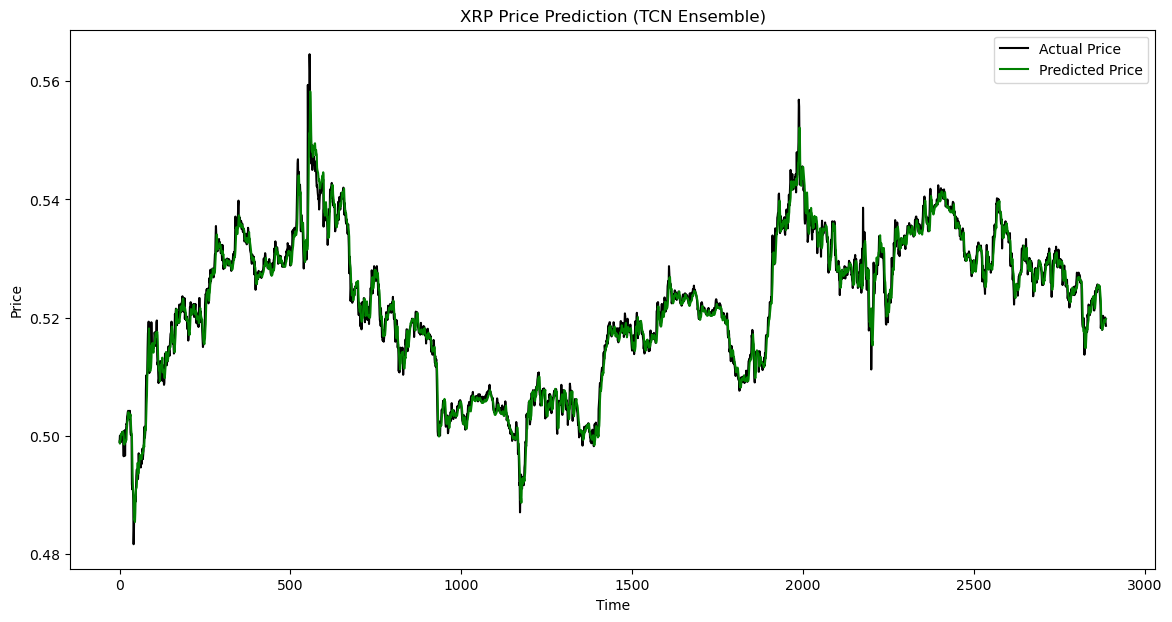

Root Mean Squared Error (RMSE) for XRP: 0.0018181488982592483
Mean Absolute Error (MAE) for XRP: 0.0012149997269182652
Mean Absolute Percentage Error (MAPE) for XRP: 0.0023226658681298877
R-squared (R²) Score for XRP: 0.9784432943245794
Mean Squared Logarithmic Error (MSLE) for XRP: 1.4186022095953656e-06
Explained Variance Score for XRP: 0.9787412955492893


In [49]:
# Training and evaluating the ensemble of TCN models per coin
for coin, data in datasets.items():
    print(f'\n\n{coin} - TCN Ensemble Model\n')
    results['TCN+Bagging'][coin] = train_and_evaluate_tcn_bagging(data, coin)

#### Training & Evaluation with Boosting Method

In [50]:
def train_tcn_boosting(data, num_models, coin): 
    seq_len = 60  # Sequence length
    x, y, scaler = preprocess_data(data, 'close', seq_len)
    num_samples = len(x)

    # Initialize a list to store trained models and their simulation results
    tcn_models = []
    simulation_results = []

    # Initialize residuals to be the target values initially
    residuals = y.copy()

    for i in range(num_models):
        # Build and train the TCN model
        tcn_model = build_tcn_model(filters_1=64, kernel_size_1=5, filters_2=32, kernel_size_2=5, dense_units=64, learning_rate=0.001)

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        tcn_model.fit(x, residuals, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping], verbose=0)

        # Make predictions using the trained model
        predictions = tcn_model.predict(x)
        
        # Calculate residuals (difference between predictions and actual values)
        residuals = y - predictions

        tcn_models.append(tcn_model)

        # Trading simulation
        final_balance, total_trades, correct_trades, incorrect_trades, annualised_return, sharpe_ratio, max_drawdown, win_ratio = simulate_trading(tcn_model, data, scaler, initial_capital, trading_fee, seq_len)

        # Store the results
        simulation_results.append({
            'final_balance': final_balance,
            'total_trades': total_trades,
            'correct_trades': correct_trades,
            'incorrect_trades': incorrect_trades,
            'annualised_return': annualised_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_ratio': win_ratio
        })

    return tcn_models, simulation_results

In [51]:
# Function to make predictions using ensemble of TCN models
def predict_tcn_boosting(models, x_test, scaler):
    # Make predictions using each TCN model
    predictions = [model.predict(x_test) for model in models]
    
    # Aggregate predictions from all TCN models
    ensemble_prediction = np.sum(predictions, axis=0)

    # Inverse transform the predictions
    ensemble_prediction = scaler.inverse_transform(ensemble_prediction)
    
    return ensemble_prediction

In [52]:
# Function to train and evaluate the ensemble of TCN models with boosting
def train_and_evaluate_tcn_boosting(data, coin, num_models=5):
    # Train TCN models with boosting and collect simulation results
    tcn_models, simulation_results = train_tcn_boosting(data, num_models, coin)

    start_time = time.time()  # For keeping track of time taken to run the model
    
    seq_len = 60  # Sequence length
    x, y, scaler = preprocess_data(data, 'close', seq_len)

    # Split the data into training, validation, and test sets
    split = int(0.8 * len(x))
    x_train, x_val, x_test = x[:split], x[split:], x[split:]
    y_train, y_val, y_test = y[:split], y[split:], y[split:]

    # Making predictions using the ensemble of TCN models with boosting
    predicted_prices = predict_tcn_boosting(tcn_models, x_test, scaler)

    # Actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(14, 7))
    plt.plot(actual_prices, color='black', label='Actual Price')
    plt.plot(predicted_prices, color='green', label='Predicted Price')
    plt.title(f'{coin} Price Prediction (TCN Ensemble with Boosting)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    msle = mean_squared_log_error(actual_prices, predicted_prices)
    explained_variance = explained_variance_score(actual_prices, predicted_prices)
    
    print(f'Root Mean Squared Error (RMSE) for {coin}: {rmse}')
    print(f'Mean Absolute Error (MAE) for {coin}: {mae}')
    print(f'Mean Absolute Percentage Error (MAPE) for {coin}: {mape}')
    print(f'R-squared (R²) Score for {coin}: {r2}')
    print(f'Mean Squared Logarithmic Error (MSLE) for {coin}: {msle}')
    print(f'Explained Variance Score for {coin}: {explained_variance}')

    end_time = time.time()  # Stop time
    time_taken = end_time - start_time  # Calculating the elapsed time

    # Aggregate simulation results
    aggregated_results = {
        'final_balance': np.mean([result['final_balance'] for result in simulation_results]),
        'total_trades': np.mean([result['total_trades'] for result in simulation_results]),
        'correct_trades': np.mean([result['correct_trades'] for result in simulation_results]),
        'incorrect_trades': np.mean([result['incorrect_trades'] for result in simulation_results]),
        'annualised_return': np.mean([result['annualised_return'] for result in simulation_results]),
        'sharpe_ratio': np.mean([result['sharpe_ratio'] for result in simulation_results]),
        'max_drawdown': np.mean([result['max_drawdown'] for result in simulation_results]),
        'win_ratio': np.mean([result['win_ratio'] for result in simulation_results])
    }

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'msle': msle,
        'explained_variance': explained_variance,
        'time_taken': time_taken,
        **aggregated_results  # Include aggregated simulation results
    }



BTC - TCN Ensemble Model with Boosting



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


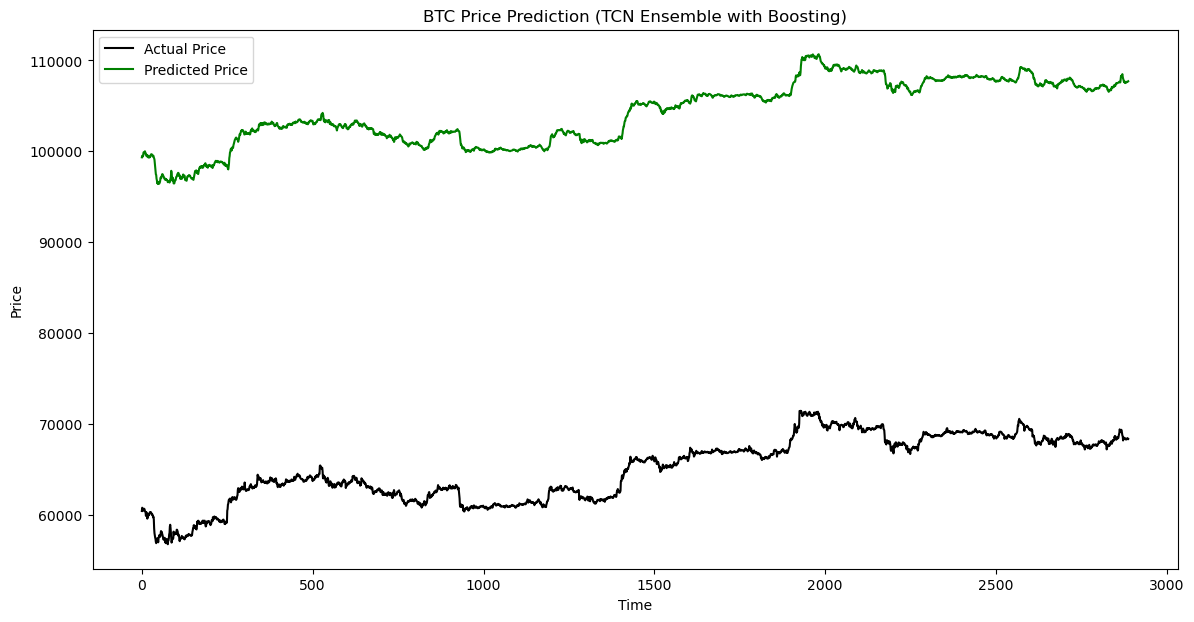

Root Mean Squared Error (RMSE) for BTC: 39200.54934345284
Mean Absolute Error (MAE) for BTC: 39198.906812240304
Mean Absolute Percentage Error (MAPE) for BTC: 0.604986741993813
R-squared (R²) Score for BTC: -120.29061954396504
Mean Squared Logarithmic Error (MSLE) for BTC: 0.2240799875621314
Explained Variance Score for BTC: 0.9898358845516921


ETH - TCN Ensemble Model with Boosting



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


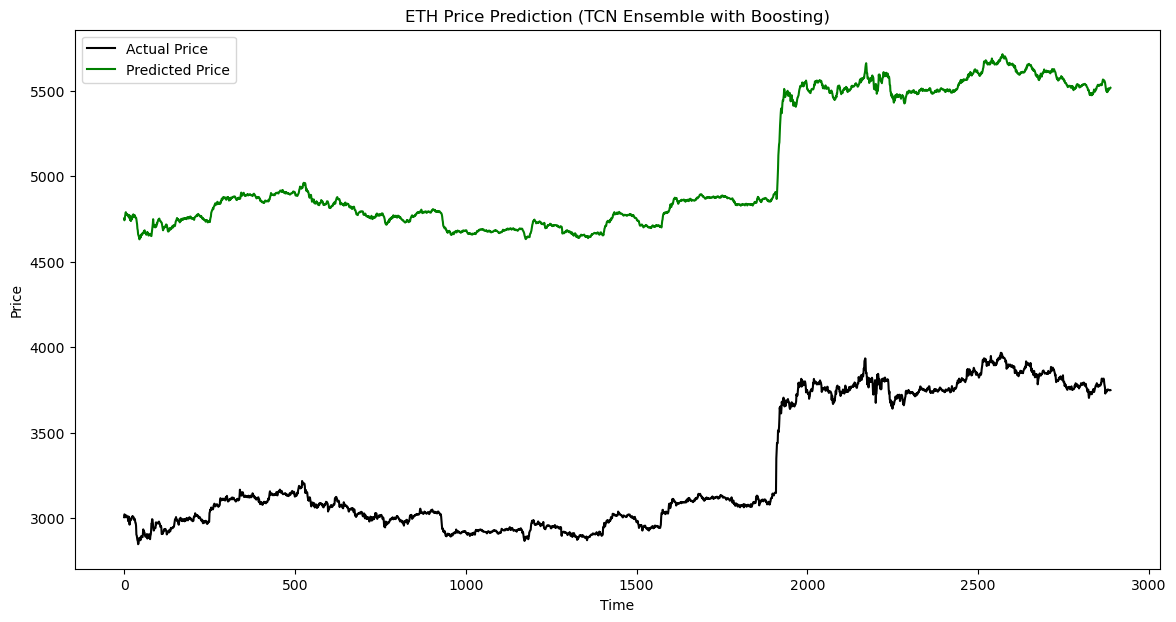

Root Mean Squared Error (RMSE) for ETH: 1759.7722203870917
Mean Absolute Error (MAE) for ETH: 1759.6354401497038
Mean Absolute Percentage Error (MAPE) for ETH: 0.543794928659339
R-squared (R²) Score for ETH: -21.28491990689113
Mean Squared Logarithmic Error (MSLE) for ETH: 0.18932457446551174
Explained Variance Score for ETH: 0.9965358946574621


BNB - TCN Ensemble Model with Boosting



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


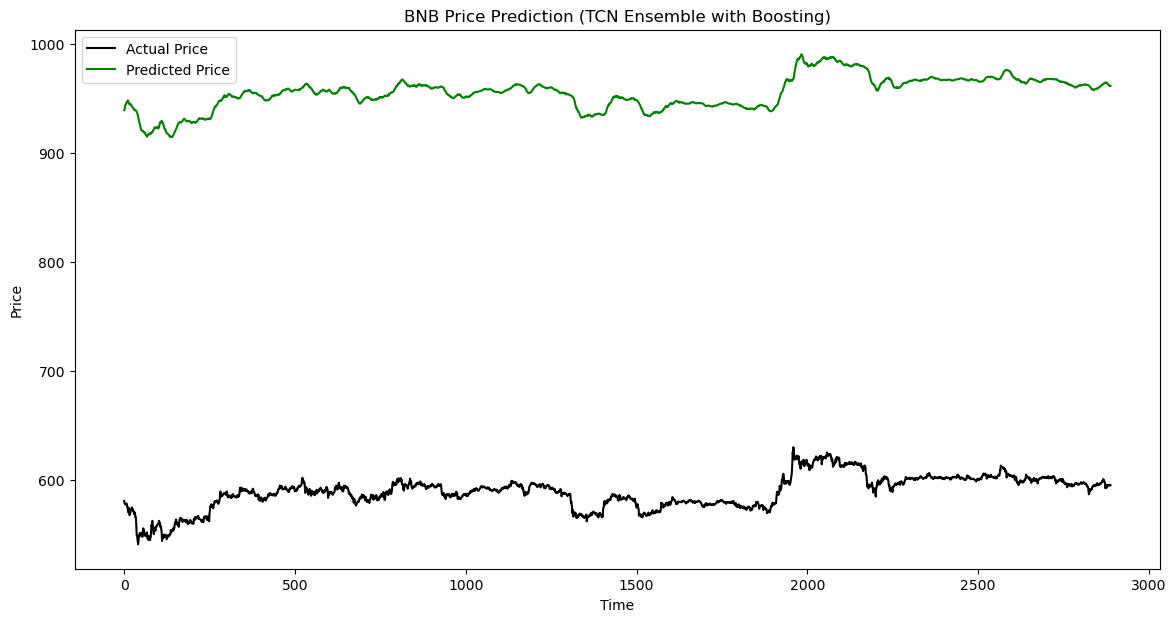

Root Mean Squared Error (RMSE) for BNB: 366.67289806878597
Mean Absolute Error (MAE) for BNB: 366.6536248204451
Mean Absolute Percentage Error (MAPE) for BNB: 0.6230605718678891
R-squared (R²) Score for BNB: -593.409764849417
Mean Squared Logarithmic Error (MSLE) for BNB: 0.23399755889037177
Explained Variance Score for BNB: 0.937514302305871


LTC - TCN Ensemble Model with Boosting



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


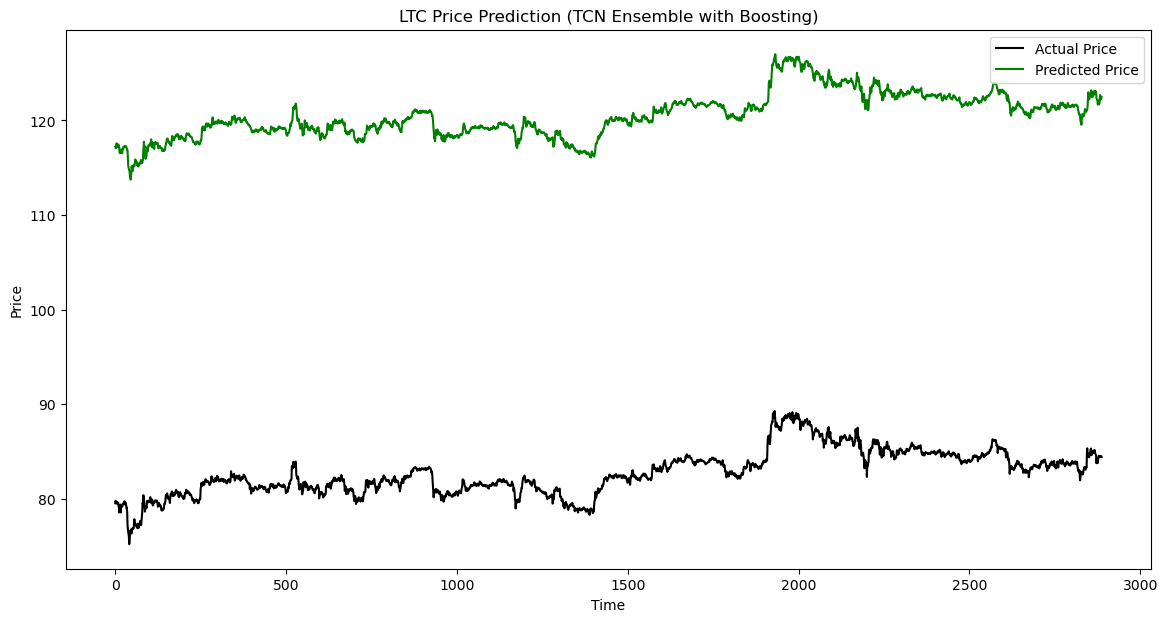

Root Mean Squared Error (RMSE) for LTC: 37.779555143345355
Mean Absolute Error (MAE) for LTC: 37.77807965540159
Mean Absolute Percentage Error (MAPE) for LTC: 0.4569341740544715
R-squared (R²) Score for LTC: -260.29577287993556
Mean Squared Logarithmic Error (MSLE) for LTC: 0.13886861672271422
Explained Variance Score for LTC: 0.9795904831313608


XRP - TCN Ensemble Model with Boosting



C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


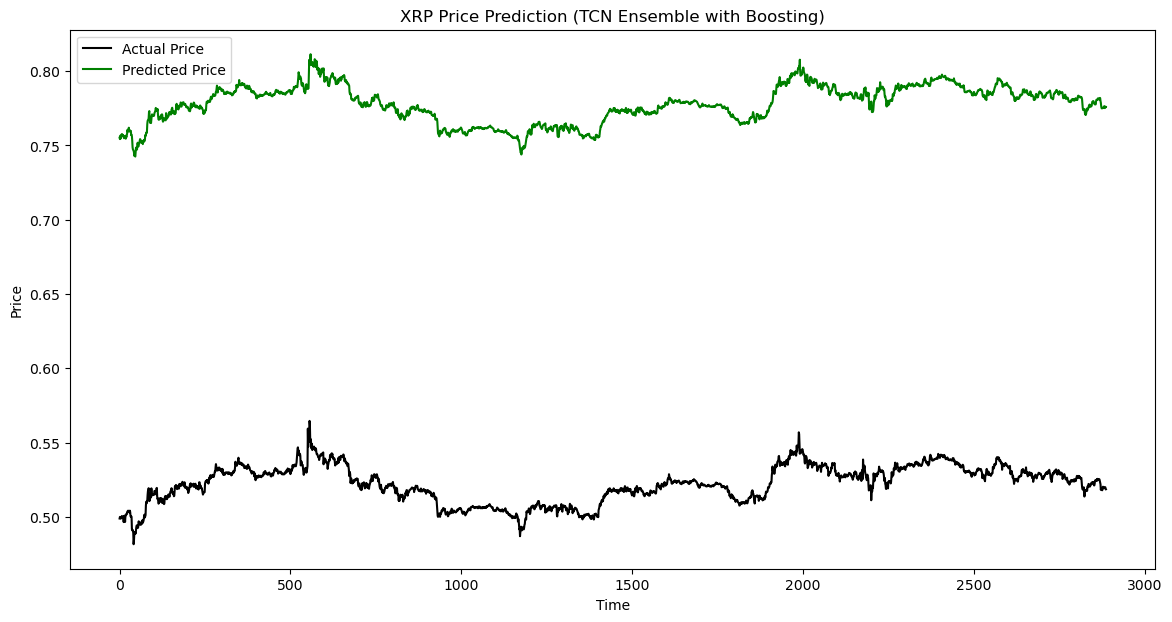

Root Mean Squared Error (RMSE) for XRP: 0.2556772844010269
Mean Absolute Error (MAE) for XRP: 0.25566810740737705
Mean Absolute Percentage Error (MAPE) for XRP: 0.4900560053965619
R-squared (R²) Score for XRP: -425.29259405306465
Mean Squared Logarithmic Error (MSLE) for XRP: 0.02411637911081551
Explained Variance Score for XRP: 0.9693988128058082


In [53]:
# Training and evaluating the ensemble of TCN models with boosting per coin
for coin, data in datasets.items():
    print(f'\n\n{coin} - TCN Ensemble Model with Boosting\n')
    results['TCN+Boosting'][coin] = train_and_evaluate_tcn_boosting(data, coin)

## Comparison of Models

In [83]:
# Run only to clear current results.json and inputting results from current kernel
with open('results.json', 'w') as f:
    json.dump(results, f)

In [84]:
# Displaying content of results.json
with open('results.json', 'r') as file:
    data = json.load(file)

for section, results in data.items():
    print(section)
    df = pd.DataFrame(results)
    display(df)
    print("\n")

display_results(data)

Buy_and_Hold_Results


Coin  Cumulative_Return  Final_Price  Total_Trades
0  BTC           0.608741      1605.53             0
1  ETH           0.631860      1628.60             0
2  BNB           0.896431      1892.64             0
3  LTC           0.153752      1151.45             0
4  XRP          -0.158800       839.52             0




Naive_Forecast_Results


Coin         MAE           MSE        RMSE      MAPE       DA
0  BTC  116.167000  32336.400000  179.823000  0.197018  47.5235
1  ETH    7.027830    120.409000   10.973100  0.225268  48.0477
2  BNB    1.098400      3.086590    1.756870  0.229326  44.4123
3  LTC    0.218530      0.133055    0.364767  0.265350  46.2541
4  XRP    0.001367      0.000006    0.002366  0.241135  44.8331




ARIMA_Results


Coin         RMSE          MAE     MAPE       R2      MSLE  Exp_Variance
0  BTC  5798.920000  4883.350000  7.28793 -1.64354  0.008166 -1.161350e-06
1  ETH   477.276000   322.821000  8.83724 -0.64132  0.020159  2.204310e-07
2  BNB    22.908500    19.809200  3.32560 -1.31869  0.001522 -3.180200e-06
3  LTC     4.821540     4.259500  5.07725 -3.22099  0.003405 -1.033250e-05
4  XRP     0.027778     0.024999  4.73731 -3.97761  0.000337  6.318350e-06




LSTM_Results


Coin        RMSE         MAE      MAPE        R2      MSLE  Exp_Variance  \
0  BTC  328.579000  214.256000  0.003373  0.991478  0.000028      0.991711   
1  ETH   22.230000   14.221500  0.004264  0.996444  0.000043      0.996458   
2  BNB    2.698640    1.817590  0.003097  0.967803  0.000021      0.967856   
3  LTC    0.327369    0.229881  0.002786  0.980380  0.000015      0.980399   
4  XRP    0.001852    0.001257  0.002405  0.977640  0.000001      0.977640   

   Final_Balance  Total_Trades  Time_Taken  Correct_Trades  Incorrect_Trades  
0        1102.74            18    123.8300               6                12  
1        1134.31            12    104.2680               4                 8  
2        1082.20            10     45.7954               6                 4  
3        1088.34            10    147.4560               3                 7  
4        1290.38            45    103.7860              27                18




TCN_Results


Coin        RMSE         MAE      MAPE        R2      MSLE  Exp_Variance  \
0  BTC  261.075000  176.850000  0.002738  0.994620  0.000017      0.994744   
1  ETH   18.104500   10.928000  0.003288  0.997641  0.000029      0.997643   
2  BNB    2.267120    1.504070  0.002565  0.977276  0.000015      0.977317   
3  LTC    0.339440    0.232985  0.002816  0.978907  0.000016      0.978908   
4  XRP    0.001919    0.001268  0.002424  0.975977  0.000002      0.975986   

   Final_Balance  Total_Trades  Time_Taken  Correct_Trades  Incorrect_Trades  
0        1102.49            18     12.5831              10                 8  
1        1128.44            18     10.1456              12                 6  
2        1226.19            30     12.1174              15                15  
3        1151.60            14     12.2175               9                 5  
4        1330.55            47     16.3604              22                25




TCN_Bagging_Results


Coin        RMSE         MAE      MAPE        R2      MSLE  Exp_Variance  \
0  BTC  239.542000  159.764000  0.002475  0.995471  0.000014      0.995485   
1  ETH   16.353900    9.834570  0.002958  0.998075  0.000024      0.998080   
2  BNB    2.035120    1.361870  0.002320  0.981689  0.000012      0.981788   
3  LTC    0.307700    0.212313  0.002566  0.982667  0.000014      0.983010   
4  XRP    0.001818    0.001215  0.002323  0.978443  0.000001      0.978741   

   Final_Balance  Total_Trades  Time_Taken  Correct_Trades  Incorrect_Trades  
0        1124.68          20.0     1.36921            11.6               8.4  
1        1071.60          10.8     1.23691             5.2               5.6  
2        1161.08          22.4     1.44807            11.6              10.8  
3        1206.24          22.0     1.25642            11.4              10.6  
4        1289.37          45.0     1.23195            24.2              20.8




TCN_Boosting_Results


Coin          RMSE           MAE      MAPE        R2      MSLE  \
0  BTC  39200.500000  39198.900000  0.604987 -120.2910  0.224080   
1  ETH   1759.770000   1759.640000  0.543795  -21.2849  0.189325   
2  BNB    366.673000    366.654000  0.623061 -593.4100  0.233998   
3  LTC     37.779600     37.778100  0.456934 -260.2960  0.138869   
4  XRP      0.255677      0.255668  0.490056 -425.2930  0.024116   

   Exp_Variance  Final_Balance  Total_Trades  Time_Taken  Correct_Trades  \
0      0.989836        1125.09          18.0     1.53149            12.0   
1      0.996536        1088.41          15.6     1.38932             9.2   
2      0.937514        1135.67          18.8     1.24340            11.6   
3      0.979590        1219.98          27.2     1.35692            15.8   
4      0.969399        1227.69          45.0     1.24509            25.4   

   Incorrect_Trades  
0               6.0  
1               6.4  
2               7.2  
3              11.4  
4              19.6